In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder as OHE
from matplotlib.patches import Ellipse
import math
import matplotlib.pyplot as plt
from scipy import stats
import scipy.sparse as sparse
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from keras import backend as K
import h3pandas

In [3]:
df_main = pd.read_csv("H:\\taxi_2017_complete_preprocessed.csv")
df_main .head()

,Unnamed: 0,start_time,end_time,trip_seconds,trip_miles,start_census,end_census,start_community,end_community,fare,...,Dropoff Centroid Location,new_TaxiID,dur_min,date,weekday,avg_temp,precip,hour,day,month
0,0,2017-01-01 00:00:00,2017-01-01 00:30:00,1800.0,0.0,1.703108e+10,1.703108e+10,8,8,13.25,...,POINT (-87.6262149064 41.8925077809),2751,30.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
1,1,2017-01-01 00:00:00,2017-01-01 00:00:00,660.0,2.7,NaN,NaN,2,3,10.00,...,POINT (-87.6558787862 41.96581197),5058,11.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
2,2,2017-01-01 00:00:00,2017-01-01 00:15:00,120.0,0.5,NaN,NaN,16,16,4.50,...,POINT (-87.7234523905 41.9535821253),5047,2.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
3,3,2017-01-01 00:00:00,2017-01-01 00:00:00,240.0,1.3,1.703184e+10,1.703183e+10,32,28,6.25,...,POINT (-87.6572331997 41.8852813201),2416,4.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1
4,4,2017-01-01 00:00:00,2017-01-01 00:00:00,420.0,0.0,1.703128e+10,1.703184e+10,28,32,6.00,...,POINT (-87.6327464887 41.8809944707),3952,7.0,2017-01-01 00:00:00,6,-0.6,0.0,0,1,1


In [4]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [5]:
#work_data = df.loc[:, ("start_census","weekday","hour","day","month","avg_temp","start_latitude","start_longitude")]
work_data = df_main.loc[:, ("start_census","hour","start_latitude","start_longitude","weekday","day","month")]
work_data = work_data.dropna()
work_data["lat"] = work_data["start_latitude"]
work_data["lng"] = work_data["start_longitude"]
work_data = work_data.drop('start_latitude', axis=1)
work_data = work_data.drop('start_longitude', axis=1)
work_data

,start_census,hour,weekday,avg_temp,day,month,lat,lng
0,1.703108e+10,0,6,-0.6,1,1,41.893216,-87.637844
3,1.703184e+10,0,6,-0.6,1,1,41.880994,-87.632746
4,1.703128e+10,0,6,-0.6,1,1,41.879255,-87.642649
5,1.703108e+10,0,6,-0.6,1,1,41.900221,-87.629105
6,1.703184e+10,0,6,-0.6,1,1,41.880994,-87.632746
...,...,...,...,...,...,...,...,...
21737159,1.703108e+10,23,6,-12.8,31,12,41.892042,-87.631864
21737160,1.703108e+10,23,6,-12.8,31,12,41.892508,-87.626215
21737162,1.703108e+10,23,6,-12.8,31,12,41.891972,-87.612945
21737163,1.703124e+10,23,6,-12.8,31,12,41.906026,-87.675312


In [24]:
def create_dataset_more_data2(data, resolution=4, use_h3=True, h3_res = 3):
    df = data.copy()
    if use_h3:
        df = df.h3.geo_to_h3(h3_res)
        df["h3"] = df.index
    
        df = df.loc[:, ("start_census","weekday","hour","month", "h3")].copy()
        df.reset_index(inplace=True, drop=True)
        df = df.dropna()
        #print(df.head())
        
        if resolution != 24:
            df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
            df = df.drop('hour', axis=1)
            df['new_hour'] = df['new_hour'].astype(int)
        else:
            df['new_hour'] = np.zeros(df.shape[0])
        #print(df['new_hour'])
        #print(df.head())

        df2 = df.loc[:, ("start_census","weekday","new_hour","month","h3")]
        df2["temp"] = 0
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","month","h3"]).transform('count')
        #print(df2.head())
        df2.drop_duplicates(inplace=True)
        #print(df2.head())
        #column = 'avg_temp'
        #df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())    
        #print(df2.head())
        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","month","h3")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","month","h3")].to_numpy())
        #encoded_data = sparse.hstack((encoded_data,df2['avg_temp'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data
    else:
        df = df.loc[:, ("start_census","weekday","hour","month")].copy()
        df = df.dropna()


        df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
        df = df.drop('hour', axis=1)
        df['new_hour'] = df['new_hour'].astype(int)


        df2 = df.loc[:, ("start_census","weekday","new_hour","month")]
        df2["temp"] = 0
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","month"]).transform('count')

        df2.drop_duplicates(inplace=True)
        column = 'avg_temp'
        df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())    

        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","month")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","month")].to_numpy())
        #encoded_data = sparse.hstack((encoded_data,df2['avg_temp'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data
        

In [40]:
def create_dataset_more_data(data, resolution=4, use_h3=True, h3_res = 3):
    df = data.copy()
    if use_h3:
        df = df.h3.geo_to_h3(h3_res)
        df["h3"] = df.index
    
        df = df.loc[:, ("start_census","weekday","hour","day","month", "h3")].copy()
        df.reset_index(inplace=True, drop=True)
        df = df.dropna()
        #print(df.head())
        
        if resolution != 24:
            df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
            df = df.drop('hour', axis=1)
            df['new_hour'] = df['new_hour'].astype(int)
        else:
            df['new_hour'] = np.zeros(df.shape[0])
        #print(df['new_hour'])
        #print(df.head())

        df2 = df.loc[:, ("start_census","weekday","new_hour","day","month","h3")]
        df2["temp"] = 0
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","day","month","h3"]).transform('count')
        #print(df2.head())
        df2.drop_duplicates(inplace=True)
        #print(df2.head())
        #column = 'avg_temp'
        #df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())    
        #print(df2.head())
        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","day","month","h3")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","day","month","h3")].to_numpy())
        #encoded_data = sparse.hstack((encoded_data,df2['avg_temp'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data
    else:
        df = df.loc[:, ("start_census","weekday","hour","day","month")].copy()
        df = df.dropna()

        if resolution != 24:
            df['new_hour'] = pd.cut(df['hour'], bins=range(-1, 25, resolution), labels=False)
            df = df.drop('hour', axis=1)
            df['new_hour'] = df['new_hour'].astype(int)
        else:
            df['new_hour'] = np.zeros(df.shape[0])


        df2 = df.loc[:, ("start_census","weekday","new_hour","day","month")]
        df2["temp"] = 0
        df2['occurrences'] = df2.groupby(["start_census","weekday","new_hour","day","month"]).transform('count')

        df2.drop_duplicates(inplace=True)
        #column = 'avg_temp'
        #df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())    

        one_hot_data = df2.loc[:, ("start_census","weekday","new_hour","day","month")]
        OHEt = OHE().fit(one_hot_data.to_numpy())
        encoded_data = OHEt.transform(df2.loc[:, ("start_census","weekday","new_hour","day","month")].to_numpy())
        #encoded_data = sparse.hstack((encoded_data,df2['avg_temp'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.hstack((encoded_data,df2['occurrences'].to_numpy().reshape(-1, 1)))
        encoded_data = sparse.csr_matrix(encoded_data)
        encoded_data = encoded_data.todense()

        return encoded_data
        

In [35]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [36]:
class Train_Net:
    def __init__(self, data, network, tt_size = 0.2, validation_size=0.2,
                 learning_rate = 0.01, momentum = 0.9, batch_size = 128, epochs = 5):
        self.data = data
        self.tt_size = tt_size
        self.validation_size = validation_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.network = network
        self.batch_size = batch_size
        self.epochs = epochs
        
    def train_net(self):
        train, test = train_test_split(self.data, test_size=self.tt_size)
        
        X_train = train[:,0:-1]
        Y_train = train[:,-1:]
        X_test = test[:,0:-1]
        Y_test = test[:,-1:]
        
        
        self.network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = self.learning_rate, momentum = self.momentum),
                             loss='mean_absolute_error')
        H = self.network.fit(X_train, Y_train, epochs=self.epochs, batch_size=self.batch_size, 
                             validation_split=self.validation_size, callbacks=[callback])
        print("Testset:")
        #change it so it only uses model best weights when testing test loss,
        print()
        
        test_loss = self.network.evaluate(X_test, Y_test)
        print("Test Loss: ", test_loss)
        plt.style.use("ggplot")
        plt.figure()
        epochs_plot = self.epochs
        if callback.stopped_epoch != 0:
            epochs_plot = callback.stopped_epoch + 1
        
        plt.plot(np.arange(0,epochs_plot), H.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs_plot), H.history["val_loss"], label="val_loss")
        plt.title("Training Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
        return test_loss, H, epochs_plot
    

In [43]:
lr = [0.01, 0.03, 0.05]
resolution = [1, 2, 6, 24]
result_list = []
data_sample = work_data.sample(10000000)
for i in lr:
    for j in resolution:
        data1 = create_dataset_more_data(data_sample,resolution=j,use_h3=False)
        network1 = models.Sequential()
        print(data1.shape)


        network1.add(layers.Dense(512, activation='relu', input_shape=(data1.shape[1]-1,)))
        network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
        network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
        network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
        network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
        network1.add(layers.Dense(1, activation='linear'))
          
        print("lr: ", i, " Hour_res: ", j)
        TN1 = Train_Net(data1, network1, batch_size = 512, epochs = 200, learning_rate=i)
        loss, H, epochs_plot = TN1.train_net()
        result_list.append("lr: "+ str(i)+ " Hour_res: "+ str(j)+ " Epochs before stopping:"+ str(epochs_plot) + " Test_loss: "+ str(loss) +" Demand mean value: " +str(data1[:,-1:].mean()))
result_list

(376316, 594)
lr:  0.01  Hour_res:  1
Epoch 1/200
471/471 [==============================] - 11s 22ms/step - loss: 13.2629 - val_loss: 7.9271
Epoch 2/200
471/471 [==============================] - 9s 20ms/step - loss: 6.8029 - val_loss: 6.4321
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 6.1205 - val_loss: 5.7601
Epoch 4/200
471/471 [==============================] - 10s 21ms/step - loss: 5.5935 - val_loss: 6.1980
Epoch 5/200
214/471 [============>.................] - ETA: 4s - loss: 5.4396

KeyboardInterrupt: 

(376510, 602)
lr:  0.01  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 10s 20ms/step - loss: 23.6488 - val_loss: 22.8792
Epoch 2/200
471/471 [==============================] - 10s 20ms/step - loss: 10.7060 - val_loss: 7.8481
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 7.3692 - val_loss: 7.3780
Epoch 4/200
471/471 [==============================] - 10s 21ms/step - loss: 6.4835 - val_loss: 6.0840
Epoch 5/200
471/471 [==============================] - 10s 20ms/step - loss: 6.0361 - val_loss: 6.2531
Epoch 6/200
471/471 [==============================] - 10s 20ms/step - loss: 5.7108 - val_loss: 5.7211
Epoch 7/200
471/471 [==============================] - 9s 20ms/step - loss: 5.4365 - val_loss: 5.4891
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 5.3030 - val_loss: 5.2618
Epoch 9/200
471/471 [==============================] - 10s 20ms/step - loss: 5.1948 - val_loss: 5.4348
Epoch 10/200
471/471

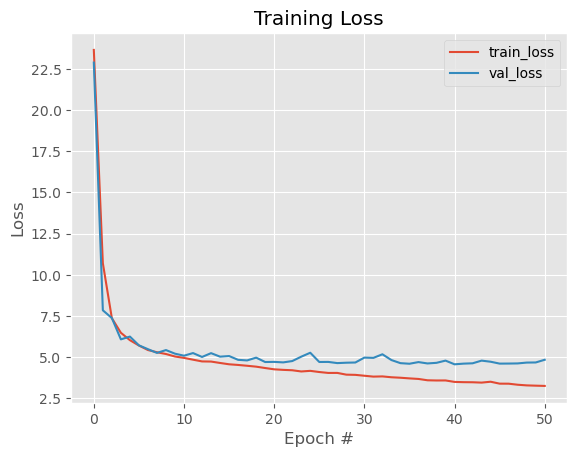

(376510, 608)
lr:  0.01  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 10s 20ms/step - loss: 23.3178 - val_loss: 23.1083
Epoch 2/200
471/471 [==============================] - 9s 20ms/step - loss: 18.5225 - val_loss: 9.8870
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 8.4884 - val_loss: 9.0057
Epoch 4/200
471/471 [==============================] - 9s 19ms/step - loss: 6.9810 - val_loss: 6.5010
Epoch 5/200
471/471 [==============================] - 9s 19ms/step - loss: 6.3181 - val_loss: 5.8790
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: 5.8701 - val_loss: 5.6054
Epoch 7/200
471/471 [==============================] - 9s 20ms/step - loss: 5.6576 - val_loss: 5.6018
Epoch 8/200
471/471 [==============================] - 9s 20ms/step - loss: 5.5768 - val_loss: 5.3776
Epoch 9/200
471/471 [==============================] - 9s 20ms/step - loss: 5.4008 - val_loss: 5.5212
Epoch 10/200
471/471 [====

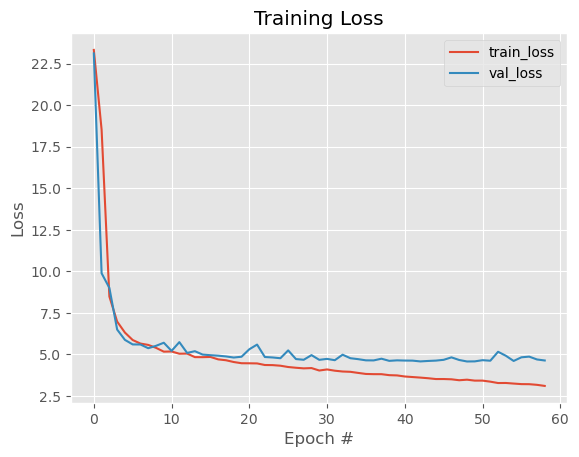

(376510, 708)
lr:  0.01  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 12s 25ms/step - loss: 11.2368 - val_loss: 6.9746
Epoch 2/200
471/471 [==============================] - 10s 22ms/step - loss: 6.5005 - val_loss: 5.9266
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 5.9301 - val_loss: 5.8026
Epoch 4/200
471/471 [==============================] - 11s 24ms/step - loss: 5.6089 - val_loss: 5.8013
Epoch 5/200
471/471 [==============================] - 10s 22ms/step - loss: 5.4083 - val_loss: 5.3629
Epoch 6/200
471/471 [==============================] - 11s 22ms/step - loss: 5.1960 - val_loss: 5.2633
Epoch 7/200
471/471 [==============================] - 10s 22ms/step - loss: 5.0523 - val_loss: 5.3928
Epoch 8/200
471/471 [==============================] - 11s 23ms/step - loss: 4.9337 - val_loss: 5.2926
Epoch 9/200
471/471 [==============================] - 10s 22ms/step - loss: 4.8384 - val_loss: 5.0524
Epoch 10/200
471/471 

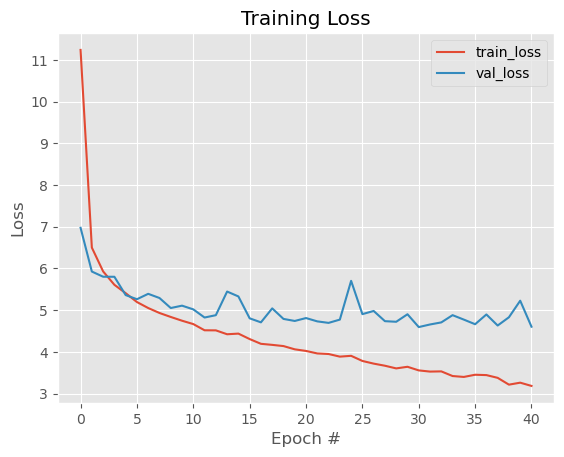

(230311, 590)
lr:  0.01  Hour_res:  2  Hex_res:  3
Epoch 1/200
288/288 [==============================] - 7s 23ms/step - loss: 40.1150 - val_loss: 40.6633
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2603 - val_loss: 42.1980
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: 40.4083 - val_loss: 40.6727
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2687 - val_loss: 40.6563
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2679 - val_loss: 40.6562
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2676 - val_loss: 40.6560
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: 40.2683 - val_loss: 40.6561
Epoch 8/200
288/288 [==============================] - 6s 21ms/step - loss: 40.2661 - val_loss: 40.6562
Epoch 9/200
288/288 [==============================] - 7s 23ms/step - loss: 40.2673 - val_loss: 40.6560
Epoch 10/200


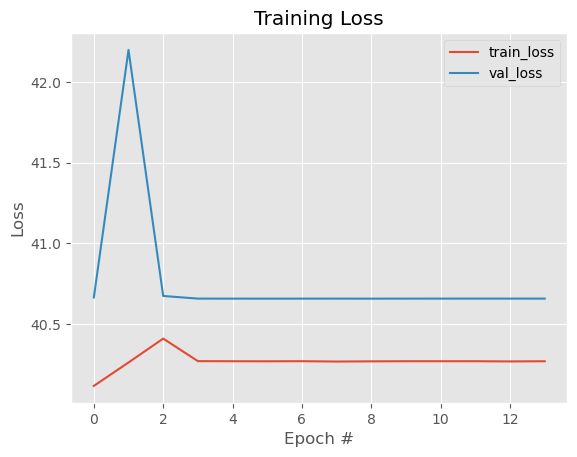

(230311, 596)
lr:  0.01  Hour_res:  2  Hex_res:  5
Epoch 1/200
288/288 [==============================] - 7s 22ms/step - loss: 39.9236 - val_loss: 38.4767
Epoch 2/200
288/288 [==============================] - 6s 21ms/step - loss: 40.1890 - val_loss: 41.0360
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: 38.8096 - val_loss: 38.8289
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: 38.1592 - val_loss: 39.2584
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: 26.7418 - val_loss: 19.1570
Epoch 6/200
288/288 [==============================] - 6s 19ms/step - loss: 14.8180 - val_loss: 14.5076
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: 12.4848 - val_loss: 11.5646
Epoch 8/200
288/288 [==============================] - 6s 20ms/step - loss: 10.8637 - val_loss: 9.9845
Epoch 9/200
288/288 [==============================] - 6s 22ms/step - loss: 9.8660 - val_loss: 9.5741
Epoch 10/200
288

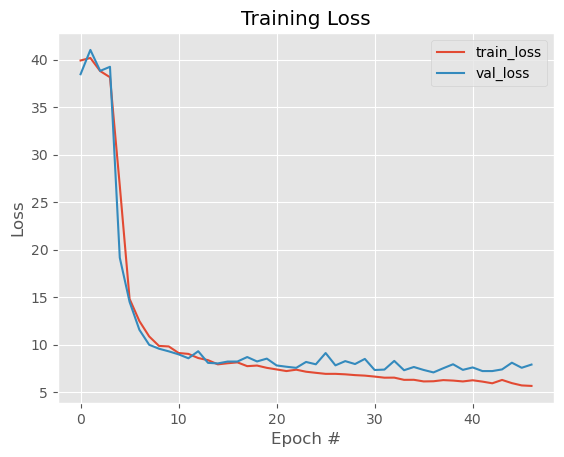

(230311, 696)
lr:  0.01  Hour_res:  2  Hex_res:  7
Epoch 1/200
288/288 [==============================] - 10s 21ms/step - loss: 21.8331 - val_loss: 13.3271
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: 11.3040 - val_loss: 9.5561
Epoch 3/200
288/288 [==============================] - 6s 22ms/step - loss: 9.8976 - val_loss: 8.7986
Epoch 4/200
288/288 [==============================] - 6s 22ms/step - loss: 9.0477 - val_loss: 8.6243
Epoch 5/200
288/288 [==============================] - 7s 26ms/step - loss: 8.8462 - val_loss: 10.0937
Epoch 6/200
288/288 [==============================] - 7s 25ms/step - loss: 8.5018 - val_loss: 10.6085
Epoch 7/200
288/288 [==============================] - 7s 24ms/step - loss: 8.3011 - val_loss: 8.2864
Epoch 8/200
288/288 [==============================] - 6s 21ms/step - loss: 7.7489 - val_loss: 8.3328
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: 7.7088 - val_loss: 11.7475
Epoch 10/200
288/288 [==

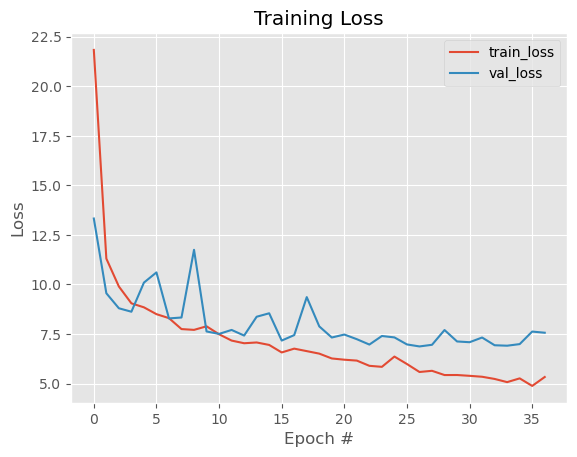

(109080, 582)
lr:  0.01  Hour_res:  6  Hex_res:  3
Epoch 1/200
137/137 [==============================] - 3s 21ms/step - loss: 87.8276 - val_loss: 89.4795
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3573 - val_loss: 89.2624
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: 88.2335 - val_loss: 89.4556
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: 88.4286 - val_loss: 89.3347
Epoch 5/200
137/137 [==============================] - 3s 21ms/step - loss: 88.5408 - val_loss: 90.8566
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3861 - val_loss: 89.2724
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3083 - val_loss: 89.2669
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3066 - val_loss: 89.2677
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: 88.3074 - val_loss: 89.2669
Epoch 10/200


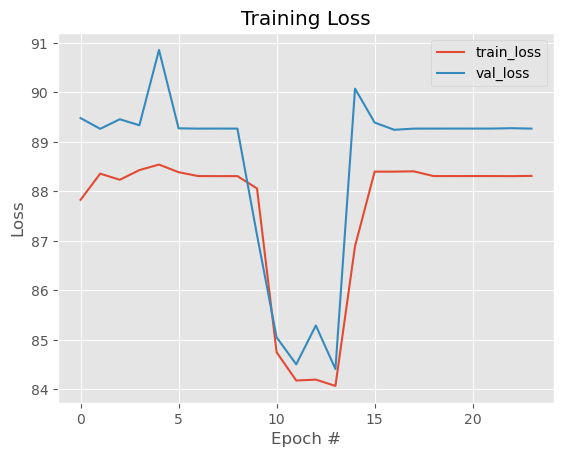

(109080, 588)
lr:  0.01  Hour_res:  6  Hex_res:  5
Epoch 1/200
137/137 [==============================] - 3s 22ms/step - loss: 88.4750 - val_loss: 87.7879
Epoch 2/200
137/137 [==============================] - 3s 21ms/step - loss: 89.1811 - val_loss: 88.1257
Epoch 3/200
137/137 [==============================] - 4s 26ms/step - loss: 88.3429 - val_loss: 89.3192
Epoch 4/200
137/137 [==============================] - 3s 22ms/step - loss: 85.6376 - val_loss: 77.3170
Epoch 5/200
137/137 [==============================] - 3s 23ms/step - loss: 81.2488 - val_loss: 80.7647
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: 80.7078 - val_loss: 79.2736
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: 80.3040 - val_loss: 78.0708
Epoch 8/200
137/137 [==============================] - 3s 23ms/step - loss: 83.9591 - val_loss: 80.3544
Epoch 9/200
137/137 [==============================] - 3s 19ms/step - loss: 80.9374 - val_loss: 81.1701
Epoch 10/200


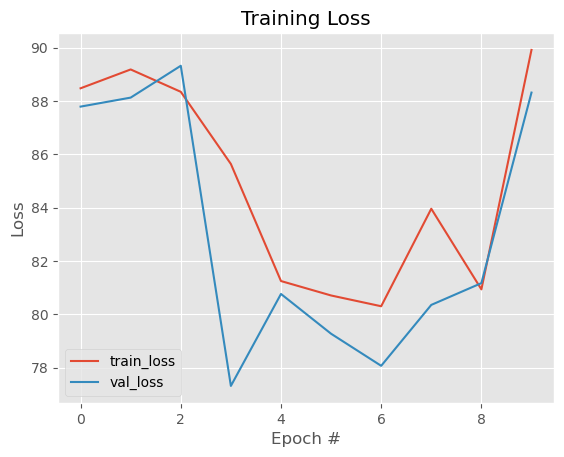

(109080, 688)
lr:  0.01  Hour_res:  6  Hex_res:  7
Epoch 1/200
137/137 [==============================] - 4s 23ms/step - loss: 82.1667 - val_loss: 108.2449
Epoch 2/200
137/137 [==============================] - 3s 21ms/step - loss: 86.2388 - val_loss: 78.8956
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: 76.8298 - val_loss: 46.5226
Epoch 4/200
137/137 [==============================] - 3s 21ms/step - loss: 37.2239 - val_loss: 34.6080
Epoch 5/200
137/137 [==============================] - 3s 22ms/step - loss: 31.3579 - val_loss: 34.8360
Epoch 6/200
137/137 [==============================] - 3s 21ms/step - loss: 28.0547 - val_loss: 23.5708
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: 20.8472 - val_loss: 20.7869
Epoch 8/200
137/137 [==============================] - 3s 21ms/step - loss: 22.1603 - val_loss: 18.9907
Epoch 9/200
137/137 [==============================] - 3s 21ms/step - loss: 19.7079 - val_loss: 21.6978
Epoch 10/200

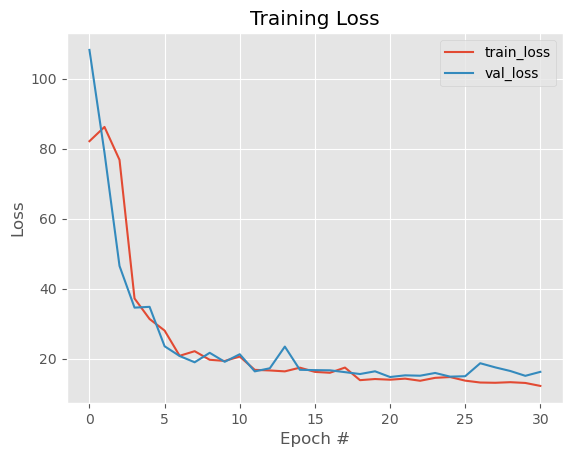

(46168, 579)
lr:  0.01  Hour_res:  24  Hex_res:  3
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 215.2069 - val_loss: 207.4716
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5696 - val_loss: 207.8926
Epoch 3/200
58/58 [==============================] - 1s 21ms/step - loss: 214.6758 - val_loss: 207.6261
Epoch 4/200
58/58 [==============================] - 2s 26ms/step - loss: 214.4224 - val_loss: 207.2372
Epoch 5/200
58/58 [==============================] - 1s 22ms/step - loss: 214.5722 - val_loss: 208.0499
Epoch 6/200
58/58 [==============================] - 1s 21ms/step - loss: 214.8783 - val_loss: 207.8775
Epoch 7/200
58/58 [==============================] - 1s 21ms/step - loss: 214.7470 - val_loss: 207.8070
Epoch 8/200
58/58 [==============================] - 1s 21ms/step - loss: 214.6445 - val_loss: 207.7566
Epoch 9/200
58/58 [==============================] - 1s 21ms/step - loss: 214.6295 - val_loss: 207.7543
Epoch 10/200


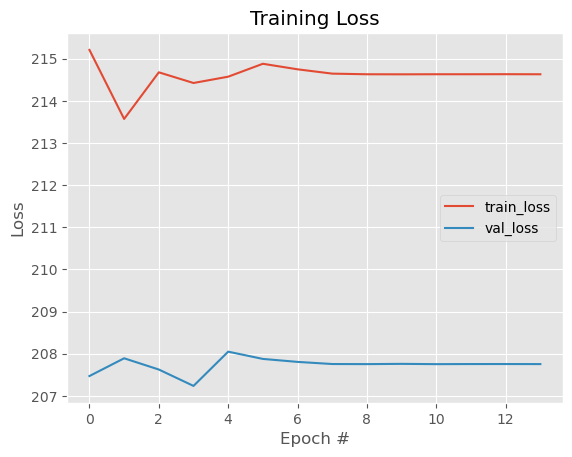

(46168, 585)
lr:  0.01  Hour_res:  24  Hex_res:  5
Epoch 1/200
58/58 [==============================] - 2s 25ms/step - loss: 210.9093 - val_loss: 201.0165
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 213.6998 - val_loss: 207.5376
Epoch 3/200
58/58 [==============================] - 1s 21ms/step - loss: 211.3895 - val_loss: 206.3260
Epoch 4/200
58/58 [==============================] - 1s 21ms/step - loss: 211.3382 - val_loss: 207.2454
Epoch 5/200
58/58 [==============================] - 1s 21ms/step - loss: 210.9613 - val_loss: 205.7983
Epoch 6/200
58/58 [==============================] - 1s 20ms/step - loss: 208.8875 - val_loss: 205.5807
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: 211.9880 - val_loss: 208.1700
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: 212.1725 - val_loss: 208.1522
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: 212.1639 - val_loss: 208.1580
Epoch 10/200


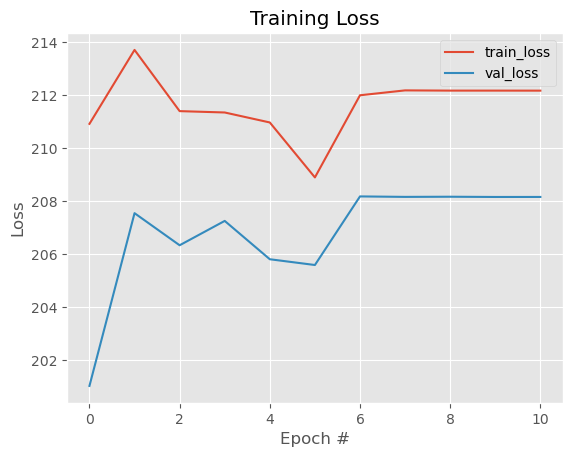

(46168, 685)
lr:  0.01  Hour_res:  24  Hex_res:  7
Epoch 1/200
58/58 [==============================] - 2s 25ms/step - loss: 212.0749 - val_loss: 164.1854
Epoch 2/200
58/58 [==============================] - 1s 21ms/step - loss: 212.4431 - val_loss: 208.4408
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: 213.6717 - val_loss: 207.6904
Epoch 4/200
58/58 [==============================] - 1s 20ms/step - loss: 213.7600 - val_loss: 207.7434
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5983 - val_loss: 207.5304
Epoch 6/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5883 - val_loss: 207.5759
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5721 - val_loss: 207.7412
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5559 - val_loss: 207.3359
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: 213.6561 - val_loss: 208.2513
Epoch 10/200


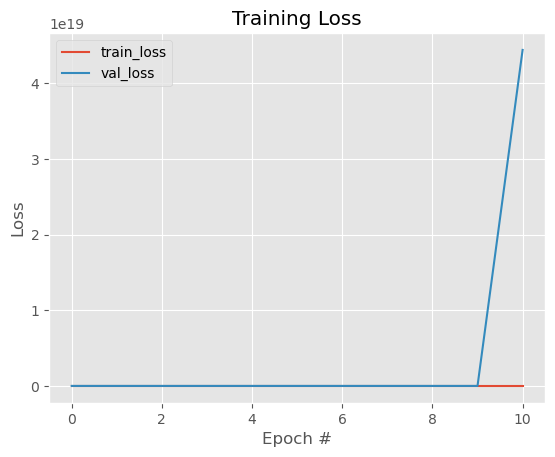

(376510, 602)
lr:  0.03  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8326 - val_loss: 23.8477
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 24.4604 - val_loss: 23.7823
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7676 - val_loss: 23.7826
Epoch 4/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7676 - val_loss: 23.7826
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7677 - val_loss: 23.7825
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: 23.7677 - val_loss: 23.7822
Epoch 7/200
471/471 [==============================] - 10s 20ms/step - loss: 23.7676 - val_loss: 23.7825
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 23.7677 - val_loss: 23.7824
Epoch 9/200
471/471 [==============================] - 9s 20ms/step - loss: 23.7677 - val_loss: 23.7829
Epoch 

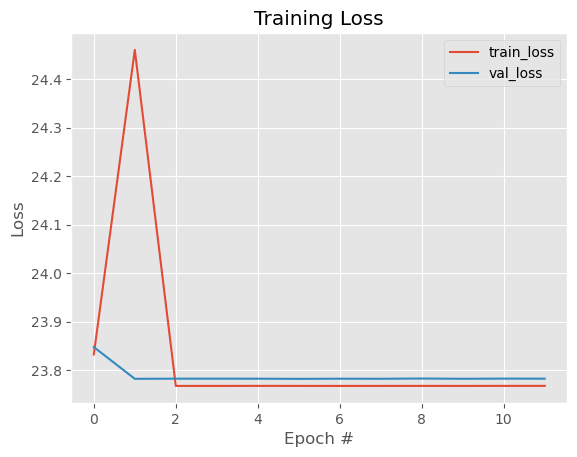

(376510, 608)
lr:  0.03  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7083 - val_loss: 23.5770
Epoch 2/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
471/471 [==============================] - 10s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
471/471 [==============================] - 9s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
471/471 [==============================] - 11s 23ms/step - loss: nan - val_loss: nan
Epoch 8/200
471/471 [==============================] - 11s 22ms/step - loss: nan - val_loss: nan
Epoch 9/200
471/471 [==============================] - 9s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
471/471 [==============================] - 9s 19ms/step - lo

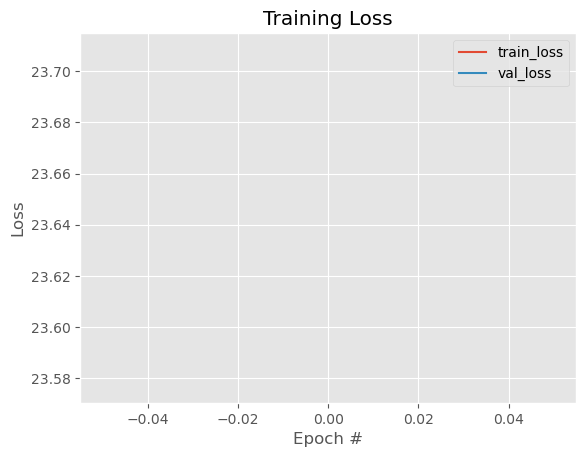

(376510, 708)
lr:  0.03  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 11s 21ms/step - loss: 10.8302 - val_loss: 8.3034
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 7.0798 - val_loss: 6.0355
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 6.3318 - val_loss: 5.8341
Epoch 4/200
471/471 [==============================] - 11s 23ms/step - loss: 6.1865 - val_loss: 6.2751
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: 5.5927 - val_loss: 5.8529
Epoch 6/200
471/471 [==============================] - 10s 20ms/step - loss: 5.6571 - val_loss: 5.7178
Epoch 7/200
471/471 [==============================] - 10s 22ms/step - loss: 5.4028 - val_loss: 6.9793
Epoch 8/200
471/471 [==============================] - 10s 21ms/step - loss: 5.3151 - val_loss: 6.1130
Epoch 9/200
471/471 [==============================] - 11s 22ms/step - loss: 5.2720 - val_loss: 5.3505
Epoch 10/200
471/471 

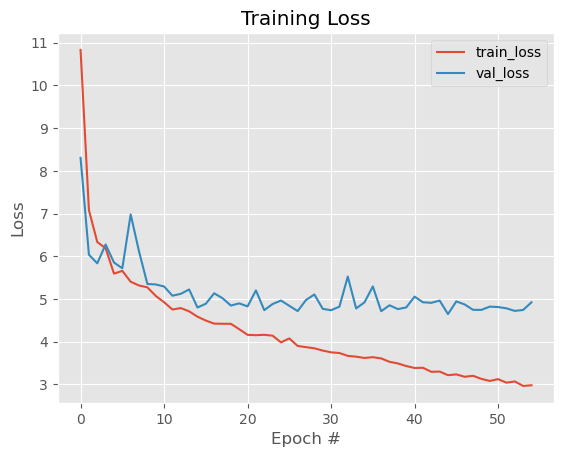

(230311, 590)
lr:  0.03  Hour_res:  2  Hex_res:  3
Epoch 1/200
288/288 [==============================] - 7s 21ms/step - loss: 40.5601 - val_loss: 41.3188
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3609 - val_loss: 41.2987
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3559 - val_loss: 41.2933
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3532 - val_loss: 41.2992
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3564 - val_loss: 41.2988
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3560 - val_loss: 41.2991
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3567 - val_loss: 41.2990
Epoch 8/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3555 - val_loss: 41.2990
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3571 - val_loss: 41.2990
Epoch 10/200


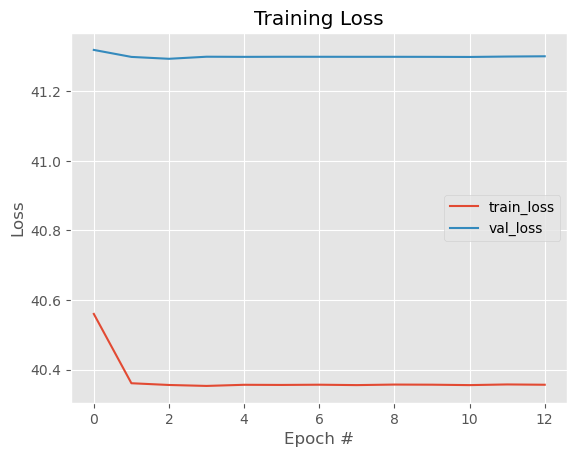

(230311, 596)
lr:  0.03  Hour_res:  2  Hex_res:  5
Epoch 1/200
288/288 [==============================] - 6s 20ms/step - loss: 40.3690 - val_loss: 40.0523
Epoch 2/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 6s 20ms/step - loss: 

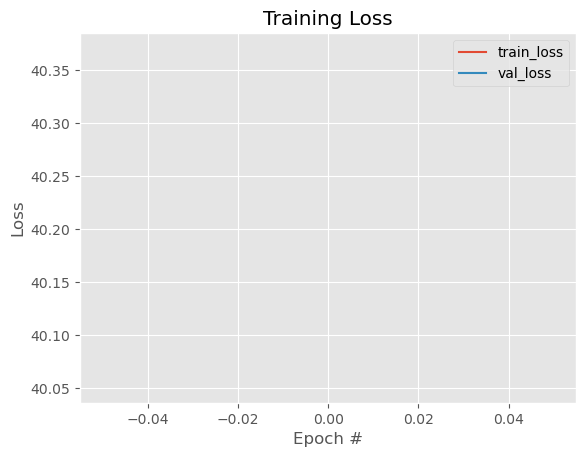

(230311, 696)
lr:  0.03  Hour_res:  2  Hex_res:  7
Epoch 1/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 6s 21ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 7s 23ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 7s 23ms/step - loss: nan - va

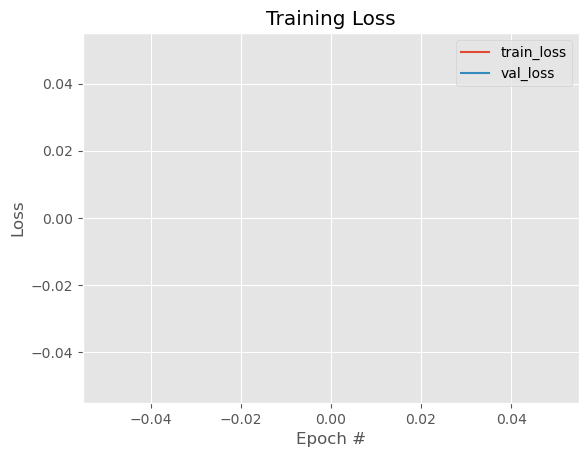

(109080, 582)
lr:  0.03  Hour_res:  6  Hex_res:  3
Epoch 1/200
137/137 [==============================] - 3s 22ms/step - loss: 89.3213 - val_loss: 88.0529
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: 89.0517 - val_loss: 88.0891
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: 88.9989 - val_loss: 87.8555
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: 88.9876 - val_loss: 88.0031
Epoch 5/200
137/137 [==============================] - 3s 21ms/step - loss: 88.9613 - val_loss: 88.0046
Epoch 6/200
137/137 [==============================] - 3s 21ms/step - loss: 88.9579 - val_loss: 88.0040
Epoch 7/200
137/137 [==============================] - 3s 21ms/step - loss: 88.9570 - val_loss: 88.0024
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: 88.9580 - val_loss: 88.0031
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: 88.9581 - val_loss: 88.0023
Epoch 10/200


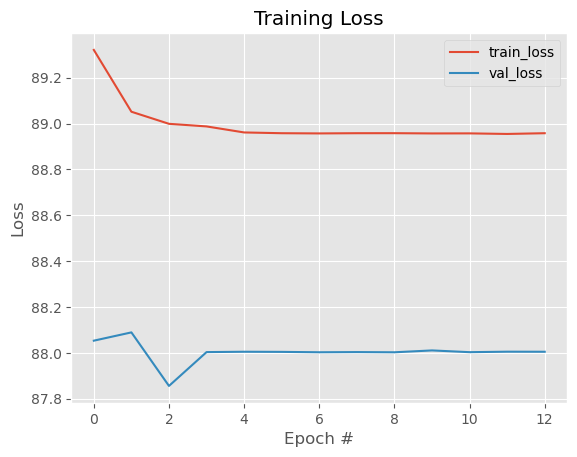

(109080, 588)
lr:  0.03  Hour_res:  6  Hex_res:  5
Epoch 1/200
137/137 [==============================] - 3s 22ms/step - loss: 88.8304 - val_loss: 87.4528
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: 89.5089 - val_loss: 88.0002
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
137/137 [==============================] - 3s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
137/137 [==============================] - 3s 20ms/step 

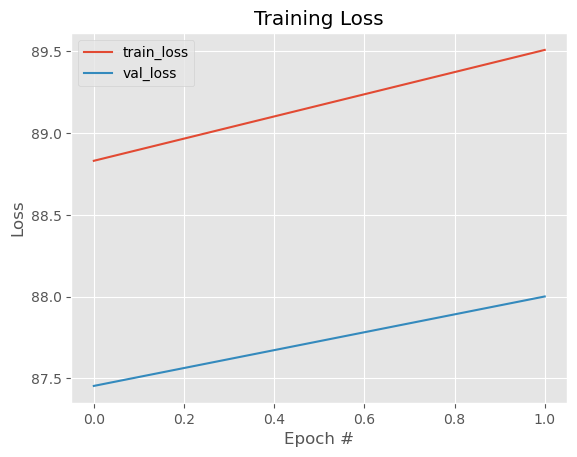

(109080, 688)
lr:  0.03  Hour_res:  6  Hex_res:  7
Epoch 1/200
137/137 [==============================] - 3s 21ms/step - loss: 87.1786 - val_loss: 87.9572
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
137/137 [==============================] - 3s 20ms/step - loss: 

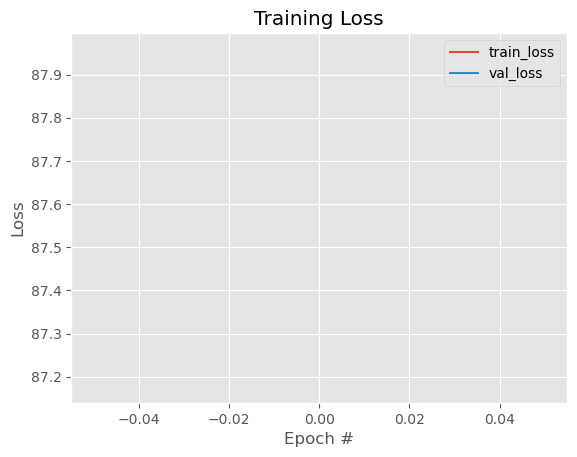

(46168, 579)
lr:  0.03  Hour_res:  24  Hex_res:  3
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 212.9266 - val_loss: 220.4954
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 212.9823 - val_loss: 219.7633
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: 212.7586 - val_loss: 219.4854
Epoch 4/200
58/58 [==============================] - 1s 19ms/step - loss: 212.5049 - val_loss: 240.9520
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: 213.8825 - val_loss: 219.7814
Epoch 6/200
58/58 [==============================] - 1s 19ms/step - loss: 212.9634 - val_loss: 219.7318
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: 212.8339 - val_loss: 219.6828
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: 212.8107 - val_loss: 219.6178
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: 212.7696 - val_loss: 219.4903
Epoch 10/200


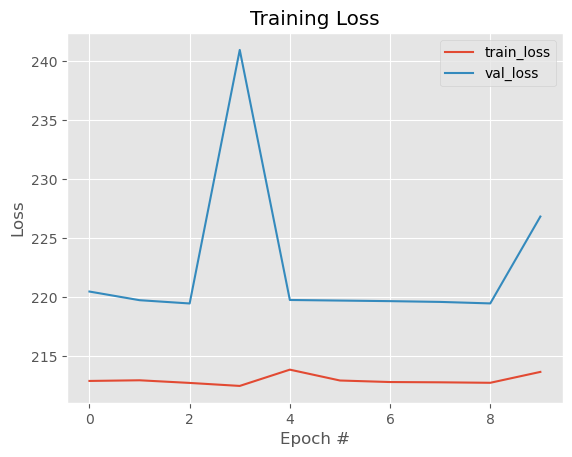

(46168, 585)
lr:  0.03  Hour_res:  24  Hex_res:  5
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 214.0269 - val_loss: 213.5286
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5236 - val_loss: 213.5512
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: 213.4585 - val_loss: 212.9871
Epoch 4/200
58/58 [==============================] - 1s 21ms/step - loss: 217.6487 - val_loss: 195.7196
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
58/58 [==============================] - 1s 20ms/s

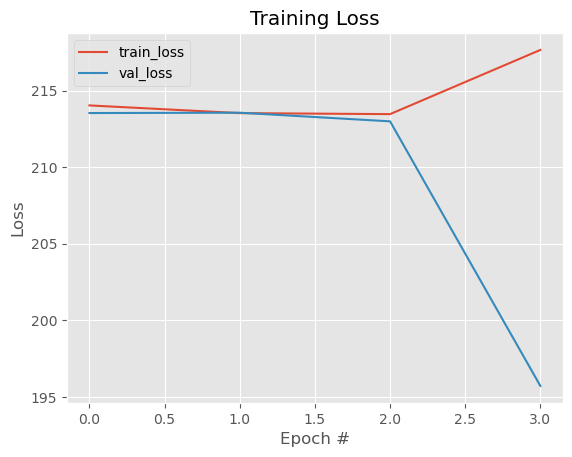

(46168, 685)
lr:  0.03  Hour_res:  24  Hex_res:  7
Epoch 1/200
58/58 [==============================] - 2s 24ms/step - loss: 212.5221 - val_loss: 200.9073
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 213.4744 - val_loss: 201.1149
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: 215.2305 - val_loss: 207.0529
Epoch 4/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
58/58 [==============================] - 1s 21ms/step - loss: nan - val_loss: nan
Epoch 10/200
58/58 [==============================] - 1s 20ms/step - loss

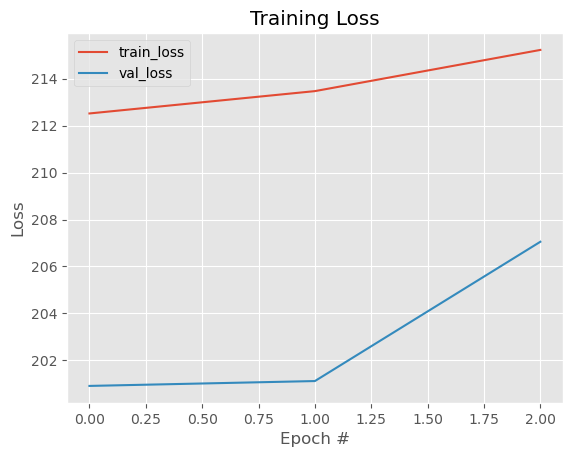

(376510, 602)
lr:  0.05  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 10s 20ms/step - loss: nan - val_loss: nan
Epoch 2/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 4/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 5/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 9/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 10/200
471/471 [==============================] - 9s 19ms/step - loss: nan - v

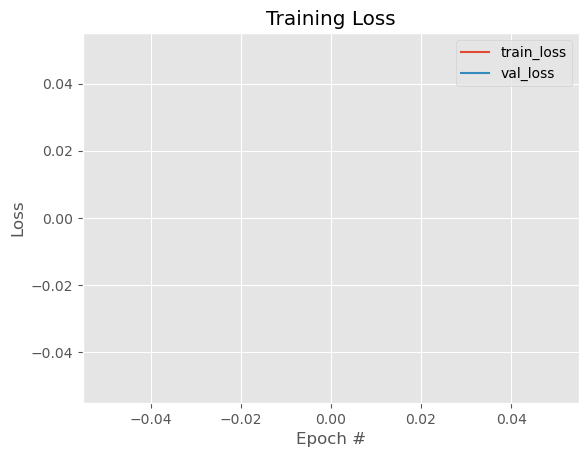

(376510, 608)
lr:  0.05  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 9s 19ms/step - loss: 23.9665 - val_loss: 23.6115
Epoch 2/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 4/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 5/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 9/200
471/471 [==============================] - 9s 19ms/step - loss: nan - val_loss: nan
Epoch 10/200
471/471 [==============================] - 9s 19ms/step - loss: 

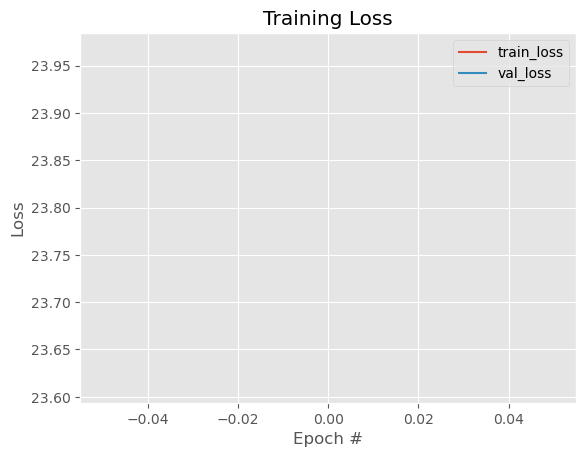

(376510, 708)
lr:  0.05  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 10s 20ms/step - loss: 21.8993 - val_loss: 18.7708
Epoch 2/200
471/471 [==============================] - 9s 20ms/step - loss: 27.0864 - val_loss: 23.7905
Epoch 3/200
471/471 [==============================] - 9s 20ms/step - loss: 23.6793 - val_loss: 23.7915
Epoch 4/200
471/471 [==============================] - 9s 19ms/step - loss: 23.6794 - val_loss: 23.7910
Epoch 5/200
471/471 [==============================] - 9s 20ms/step - loss: 23.6792 - val_loss: 23.7910
Epoch 6/200
471/471 [==============================] - 9s 19ms/step - loss: 23.6792 - val_loss: 23.7910
Epoch 7/200
471/471 [==============================] - 9s 20ms/step - loss: 23.6795 - val_loss: 23.7904
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 23.6794 - val_loss: 23.7902
Epoch 9/200
471/471 [==============================] - 10s 21ms/step - loss: 23.6794 - val_loss: 23.7903
Epoch 10/2

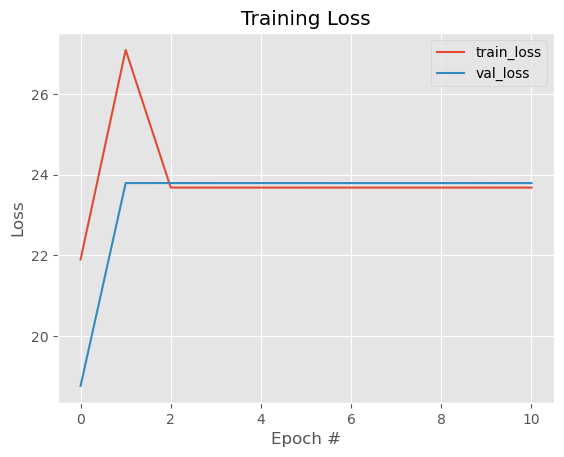

(230311, 590)
lr:  0.05  Hour_res:  2  Hex_res:  3
Epoch 1/200
288/288 [==============================] - 6s 19ms/step - loss: 40.6693 - val_loss: 40.3658
Epoch 2/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5821 - val_loss: 40.3870
Epoch 3/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5824 - val_loss: 40.3867
Epoch 4/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5825 - val_loss: 40.3886
Epoch 5/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5825 - val_loss: 40.3884
Epoch 6/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5838 - val_loss: 40.3969
Epoch 7/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5827 - val_loss: 40.3898
Epoch 8/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5832 - val_loss: 40.4065
Epoch 9/200
288/288 [==============================] - 5s 19ms/step - loss: 40.5838 - val_loss: 40.3860
Epoch 10/200


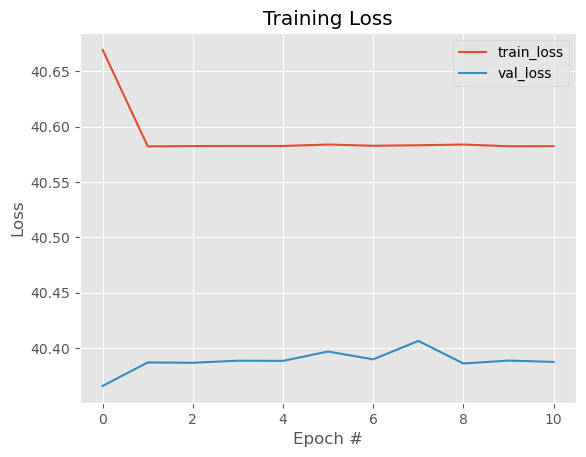

(230311, 596)
lr:  0.05  Hour_res:  2  Hex_res:  5
Epoch 1/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 6s 19ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 6s 19ms/step - loss: nan - va

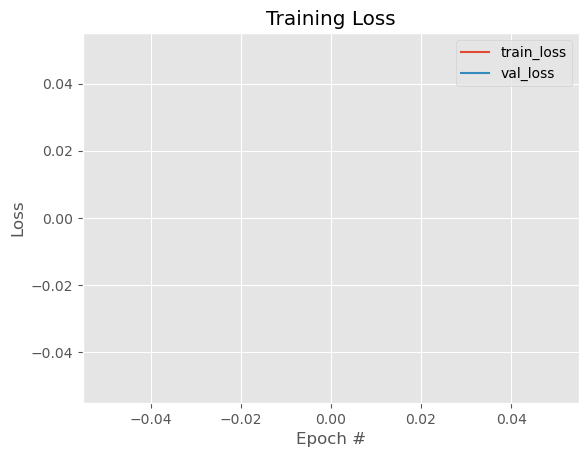

(230311, 696)
lr:  0.05  Hour_res:  2  Hex_res:  7
Epoch 1/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 2/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
288/288 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
288/288 [==============================] - 6s 20ms/step - loss: nan - va

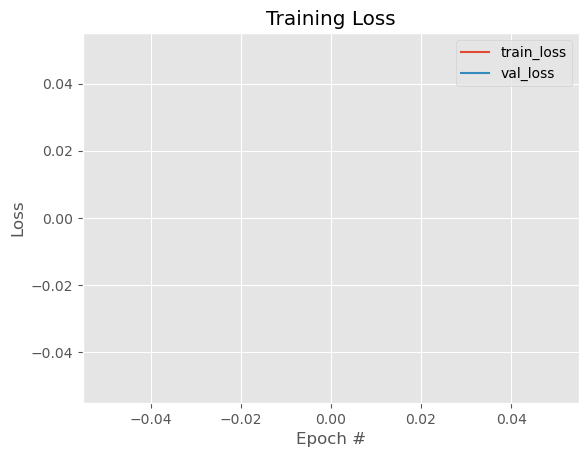

(109080, 582)
lr:  0.05  Hour_res:  6  Hex_res:  3
Epoch 1/200
137/137 [==============================] - 3s 20ms/step - loss: 88.6242 - val_loss: 89.8423
Epoch 2/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4192 - val_loss: 89.7896
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: 88.4036 - val_loss: 89.7599
Epoch 4/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4046 - val_loss: 89.7637
Epoch 5/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4048 - val_loss: 89.7618
Epoch 6/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4056 - val_loss: 89.7624
Epoch 7/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4061 - val_loss: 89.7668
Epoch 8/200
137/137 [==============================] - 3s 19ms/step - loss: 88.4071 - val_loss: 89.7630
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: 88.4051 - val_loss: 89.7655
Epoch 10/200


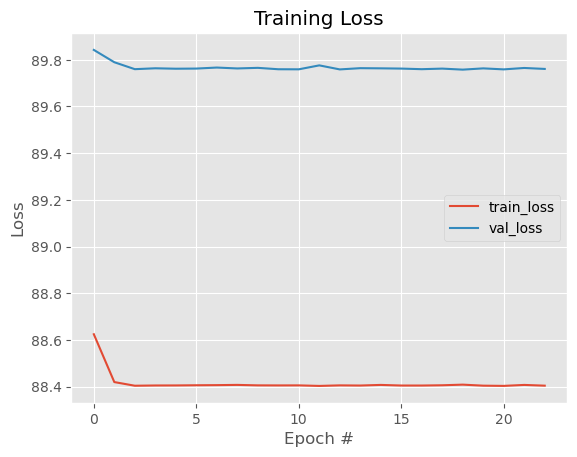

(109080, 588)
lr:  0.05  Hour_res:  6  Hex_res:  5
Epoch 1/200
137/137 [==============================] - 3s 21ms/step - loss: 88.7882 - val_loss: 88.1405
Epoch 2/200
137/137 [==============================] - 3s 19ms/step - loss: nan - val_loss: nan
Epoch 3/200
137/137 [==============================] - 3s 19ms/step - loss: nan - val_loss: nan
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
137/137 [==============================] - 3s 20ms/step - loss: 

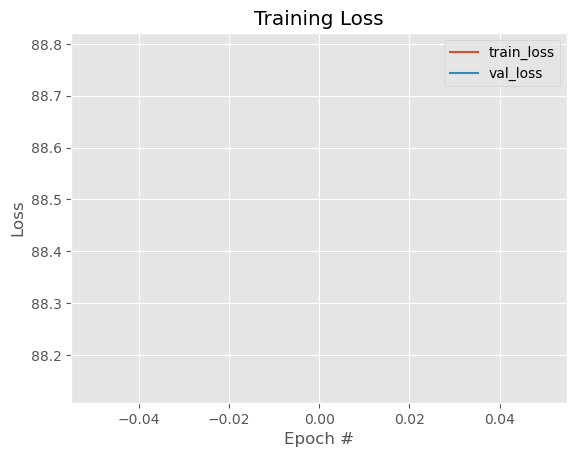

(109080, 688)
lr:  0.05  Hour_res:  6  Hex_res:  7
Epoch 1/200
137/137 [==============================] - 4s 21ms/step - loss: nan - val_loss: nan
Epoch 2/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
137/137 [==============================] - 3s 19ms/step - loss: nan - val_loss: nan
Epoch 6/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 7/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
137/137 [==============================] - 3s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
137/137 [==============================] - 3s 20ms/step - loss: nan - va

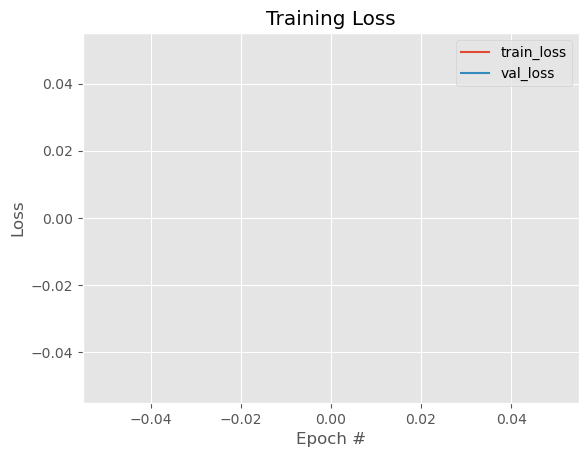

(46168, 579)
lr:  0.05  Hour_res:  24  Hex_res:  3
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 213.7915 - val_loss: 213.2817
Epoch 2/200
58/58 [==============================] - 1s 19ms/step - loss: 213.6245 - val_loss: 215.6625
Epoch 3/200
58/58 [==============================] - 1s 19ms/step - loss: 213.5662 - val_loss: 215.6424
Epoch 4/200
58/58 [==============================] - 1s 19ms/step - loss: 213.5303 - val_loss: 215.6118
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: 213.5762 - val_loss: 215.6389
Epoch 6/200
58/58 [==============================] - 1s 19ms/step - loss: 213.3870 - val_loss: 214.5312
Epoch 7/200
58/58 [==============================] - 1s 19ms/step - loss: 214.6486 - val_loss: 215.7520
Epoch 8/200
58/58 [==============================] - 1s 19ms/step - loss: 213.7077 - val_loss: 216.8880
Epoch 9/200
58/58 [==============================] - 1s 19ms/step - loss: 213.7300 - val_loss: 215.6547
Epoch 10/200


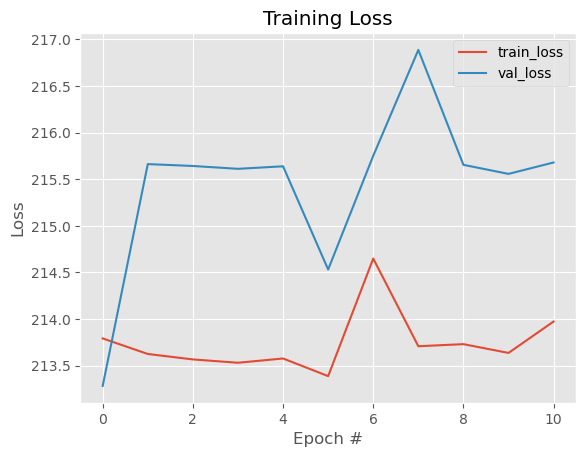

(46168, 585)
lr:  0.05  Hour_res:  24  Hex_res:  5
Epoch 1/200
58/58 [==============================] - 2s 23ms/step - loss: 211.1907 - val_loss: 214.4297
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: 212.5983 - val_loss: 211.0068
Epoch 3/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
58/58 [==============================] - 1s 19ms/step - loss: nan - va

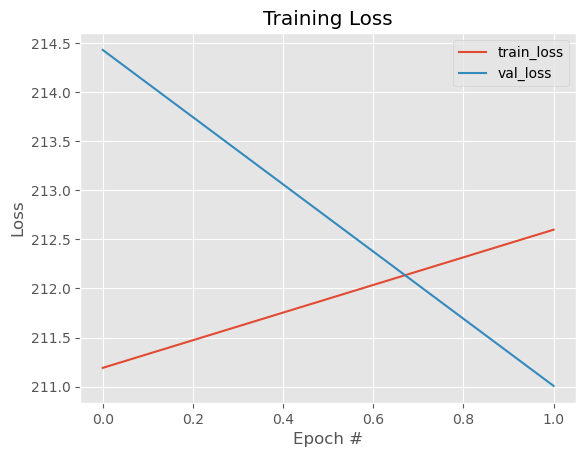

(46168, 685)
lr:  0.05  Hour_res:  24  Hex_res:  7
Epoch 1/200
58/58 [==============================] - 2s 24ms/step - loss: nan - val_loss: nan
Epoch 2/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
58/58 [==============================] - 1s 22ms/step - loss: nan - val_loss: nan
Epoch 4/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 7/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 8/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 9/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 10/200
58/58 [==============================] - 1s 20ms/step - loss: nan - val_loss: nan
Epoch 10

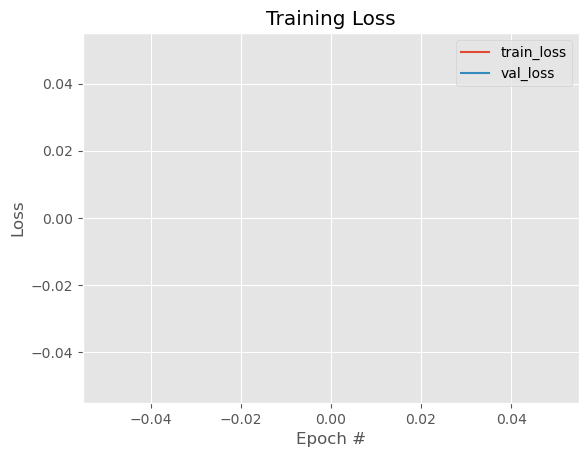

['lr: 0.01 Hour_res: 1 Hex_res: 3 Epochs before stopping:51 Test_loss: 4.6148362159729 Demand mean value: 26.55971952936177',
 'lr: 0.01 Hour_res: 1 Hex_res: 5 Epochs before stopping:59 Test_loss: 4.64540433883667 Demand mean value: 26.55971952936177',
 'lr: 0.01 Hour_res: 1 Hex_res: 7 Epochs before stopping:41 Test_loss: 4.577645778656006 Demand mean value: 26.55971952936177',
 'lr: 0.01 Hour_res: 2 Hex_res: 3 Epochs before stopping:14 Test_loss: 40.885223388671875 Demand mean value: 43.419550086622',
 'lr: 0.01 Hour_res: 2 Hex_res: 5 Epochs before stopping:47 Test_loss: 6.94142484664917 Demand mean value: 43.419550086622',
 'lr: 0.01 Hour_res: 2 Hex_res: 7 Epochs before stopping:37 Test_loss: 6.900033473968506 Demand mean value: 43.419550086622',
 'lr: 0.01 Hour_res: 6 Hex_res: 3 Epochs before stopping:24 Test_loss: 84.2301025390625 Demand mean value: 91.67583425009168',
 'lr: 0.01 Hour_res: 6 Hex_res: 5 Epochs before stopping:14 Test_loss: 74.13087463378906 Demand mean value: 91.675

In [37]:
lr = [0.01, 0.03, 0.05]
resolution = [1, 2, 6, 24]
hex_res = [3, 5, 7]
result_list = []
data_sample = work_data.sample(10000000)
for i in lr:
    for j in resolution:
        for k in hex_res:
            data1 = create_dataset_more_data(data_sample,resolution=j,h3_res = k)
            network1 = models.Sequential()
            print(data1.shape)


            network1.add(layers.Dense(512, activation='relu', input_shape=(data1.shape[1]-1,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(1, activation='linear'))
          
            print("lr: ", i, " Hour_res: ", j, " Hex_res: ", k)
            TN1 = Train_Net(data1, network1, batch_size = 512, epochs = 200, learning_rate=i)
            loss, H, epochs_plot = TN1.train_net()
            result_list.append("lr: "+ str(i)+ " Hour_res: "+ str(j)+ " Hex_res: "+str(k)+ " Epochs before stopping:"+ str(epochs_plot) + " Test_loss: "+ str(loss) +" Demand mean value: " +str(data1[:,-1:].mean()))
result_list

lr:  0.005  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 14s 21ms/step - loss: 15.1654 - val_loss: 8.3984
Epoch 2/200
471/471 [==============================] - 10s 22ms/step - loss: 7.1797 - val_loss: 6.6003
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 6.2337 - val_loss: 6.0124
Epoch 4/200
471/471 [==============================] - 11s 23ms/step - loss: 5.7818 - val_loss: 5.7213
Epoch 5/200
471/471 [==============================] - 10s 20ms/step - loss: 5.4775 - val_loss: 5.5951
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: 5.3213 - val_loss: 5.8046
Epoch 7/200
471/471 [==============================] - 10s 21ms/step - loss: 5.2403 - val_loss: 5.4935
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 5.0200 - val_loss: 5.2085
Epoch 9/200
471/471 [==============================] - 9s 20ms/step - loss: 4.9796 - val_loss: 5.8344
Epoch 10/200
471/471 [==============

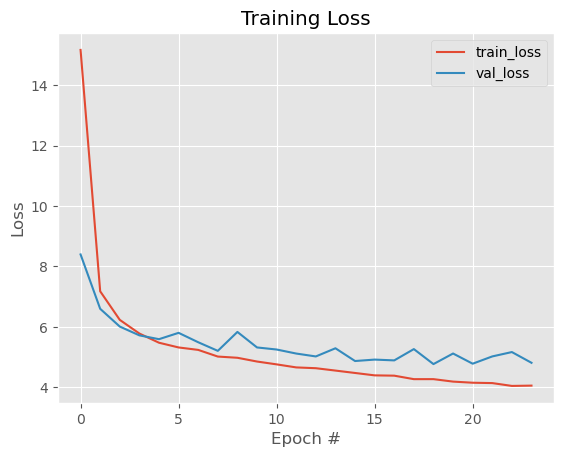

lr:  0.005  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 11s 22ms/step - loss: 14.5487 - val_loss: 7.9477
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 7.2143 - val_loss: 6.2381
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 6.1400 - val_loss: 5.8162
Epoch 4/200
471/471 [==============================] - 10s 22ms/step - loss: 5.6973 - val_loss: 5.5796
Epoch 5/200
471/471 [==============================] - 11s 24ms/step - loss: 5.5026 - val_loss: 5.5291
Epoch 6/200
471/471 [==============================] - 9s 20ms/step - loss: 5.2644 - val_loss: 5.2846
Epoch 7/200
471/471 [==============================] - 10s 21ms/step - loss: 5.0905 - val_loss: 5.1846
Epoch 8/200
471/471 [==============================] - 11s 23ms/step - loss: 4.9622 - val_loss: 5.2558
Epoch 9/200
471/471 [==============================] - 10s 22ms/step - loss: 4.8739 - val_loss: 5.1786
Epoch 10/200
471/471 [=============

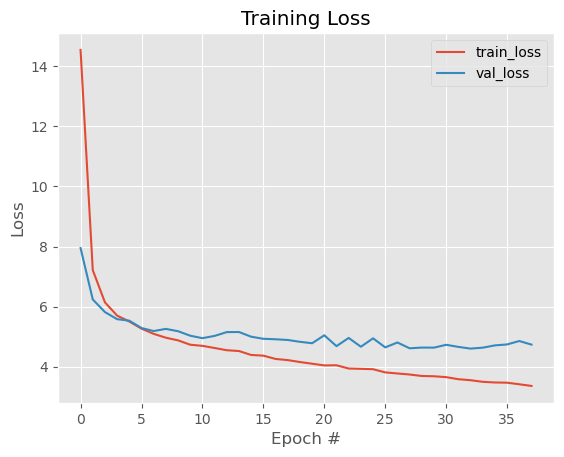

lr:  0.005  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 10s 21ms/step - loss: 13.0489 - val_loss: 8.0841
Epoch 2/200
471/471 [==============================] - 10s 20ms/step - loss: 6.8594 - val_loss: 6.1761
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 5.9858 - val_loss: 6.1229
Epoch 4/200
471/471 [==============================] - 11s 23ms/step - loss: 5.6579 - val_loss: 5.7701
Epoch 5/200
471/471 [==============================] - 11s 23ms/step - loss: 5.3574 - val_loss: 6.0869
Epoch 6/200
471/471 [==============================] - 11s 24ms/step - loss: 5.1634 - val_loss: 5.3547
Epoch 7/200
471/471 [==============================] - 10s 22ms/step - loss: 5.0905 - val_loss: 5.4185
Epoch 8/200
471/471 [==============================] - 11s 24ms/step - loss: 4.9944 - val_loss: 5.3223
Epoch 9/200
471/471 [==============================] - 11s 23ms/step - loss: 4.8439 - val_loss: 5.1590
Epoch 10/200
471/471 [============

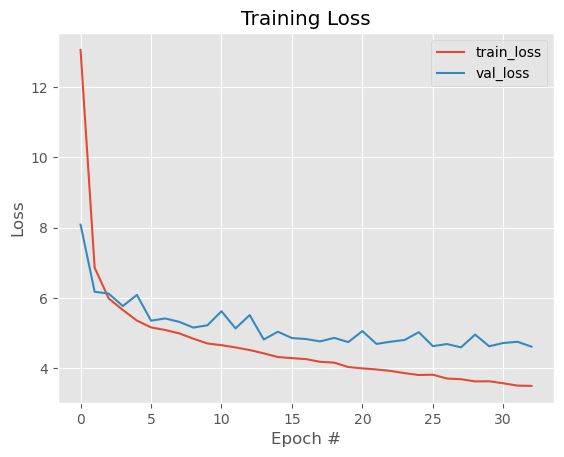

lr:  0.005  Hour_res:  1  Hex_res:  9
Epoch 1/200
471/471 [==============================] - 13s 26ms/step - loss: 14.0904 - val_loss: 7.5374
Epoch 2/200
471/471 [==============================] - 13s 27ms/step - loss: 6.8625 - val_loss: 6.1777
Epoch 3/200
471/471 [==============================] - 12s 25ms/step - loss: 6.0334 - val_loss: 5.7074
Epoch 4/200
471/471 [==============================] - 12s 26ms/step - loss: 5.6158 - val_loss: 5.7033
Epoch 5/200
471/471 [==============================] - 11s 24ms/step - loss: 5.4154 - val_loss: 5.3676
Epoch 6/200
471/471 [==============================] - 11s 24ms/step - loss: 5.1813 - val_loss: 5.2902
Epoch 7/200
471/471 [==============================] - 12s 26ms/step - loss: 5.0625 - val_loss: 5.2617
Epoch 8/200
471/471 [==============================] - 11s 24ms/step - loss: 4.9362 - val_loss: 5.4976
Epoch 9/200
471/471 [==============================] - 11s 23ms/step - loss: 4.8738 - val_loss: 5.2478
Epoch 10/200
471/471 [============

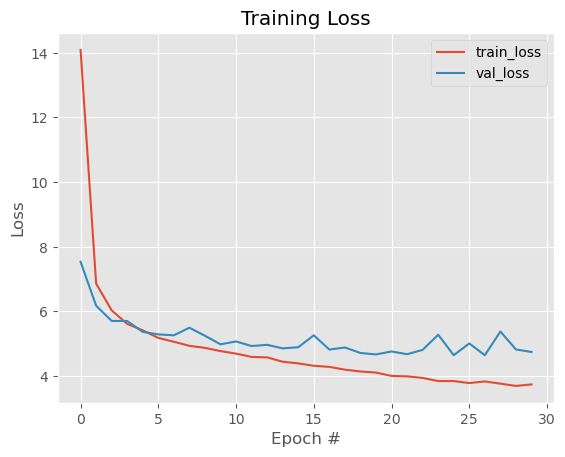

lr:  0.005  Hour_res:  2  Hex_res:  3
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 46.4705 - val_loss: 48.0773
Epoch 2/200
429/429 [==============================] - 9s 22ms/step - loss: 46.2680 - val_loss: 48.5777
Epoch 3/200
429/429 [==============================] - 11s 26ms/step - loss: 46.5172 - val_loss: 47.9927
Epoch 4/200
429/429 [==============================] - 9s 21ms/step - loss: 46.3523 - val_loss: 45.4311
Epoch 5/200
429/429 [==============================] - 9s 20ms/step - loss: 46.5003 - val_loss: 47.9405
Epoch 6/200
429/429 [==============================] - 9s 20ms/step - loss: 35.5728 - val_loss: 18.1953
Epoch 7/200
429/429 [==============================] - 9s 20ms/step - loss: 15.1737 - val_loss: 13.8918
Epoch 8/200
429/429 [==============================] - 9s 20ms/step - loss: 11.9547 - val_loss: 11.0546
Epoch 9/200
429/429 [==============================] - 9s 20ms/step - loss: 10.5813 - val_loss: 10.0086
Epoch 10/200
429/429 [==

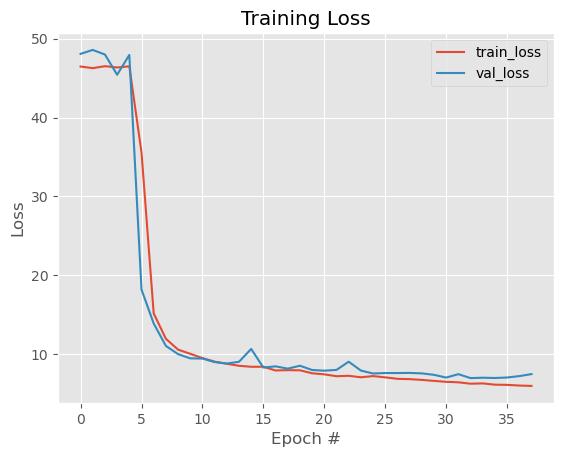

lr:  0.005  Hour_res:  2  Hex_res:  5
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 45.4301 - val_loss: 33.1640
Epoch 2/200
429/429 [==============================] - 9s 21ms/step - loss: 20.0347 - val_loss: 13.6505
Epoch 3/200
429/429 [==============================] - 9s 22ms/step - loss: 13.5084 - val_loss: 11.4045
Epoch 4/200
429/429 [==============================] - 9s 21ms/step - loss: 11.4761 - val_loss: 11.3439
Epoch 5/200
429/429 [==============================] - 8s 20ms/step - loss: 10.3831 - val_loss: 10.9086
Epoch 6/200
429/429 [==============================] - 9s 21ms/step - loss: 9.6994 - val_loss: 9.7835
Epoch 7/200
429/429 [==============================] - 8s 20ms/step - loss: 9.3016 - val_loss: 10.7376
Epoch 8/200
429/429 [==============================] - 8s 20ms/step - loss: 8.8972 - val_loss: 8.8923
Epoch 9/200
429/429 [==============================] - 9s 21ms/step - loss: 8.6816 - val_loss: 8.7256
Epoch 10/200
429/429 [==========

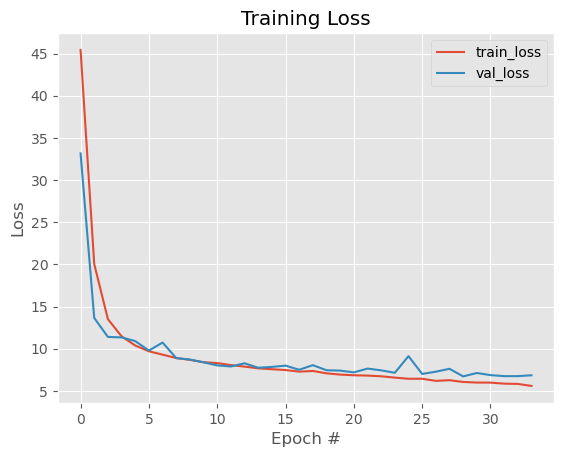

lr:  0.005  Hour_res:  2  Hex_res:  7
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 23.0313 - val_loss: 13.2257
Epoch 2/200
429/429 [==============================] - 9s 21ms/step - loss: 11.5345 - val_loss: 10.4244
Epoch 3/200
429/429 [==============================] - 9s 21ms/step - loss: 10.1355 - val_loss: 9.8265
Epoch 4/200
429/429 [==============================] - 9s 21ms/step - loss: 9.6504 - val_loss: 8.6707
Epoch 5/200
429/429 [==============================] - 9s 21ms/step - loss: 8.8818 - val_loss: 8.5316
Epoch 6/200
429/429 [==============================] - 9s 21ms/step - loss: 8.7374 - val_loss: 8.3038
Epoch 7/200
429/429 [==============================] - 9s 21ms/step - loss: 8.2199 - val_loss: 8.7456
Epoch 8/200
429/429 [==============================] - 9s 21ms/step - loss: 7.9770 - val_loss: 7.8790
Epoch 9/200
429/429 [==============================] - 10s 23ms/step - loss: 7.7318 - val_loss: 8.2089
Epoch 10/200
429/429 [===============

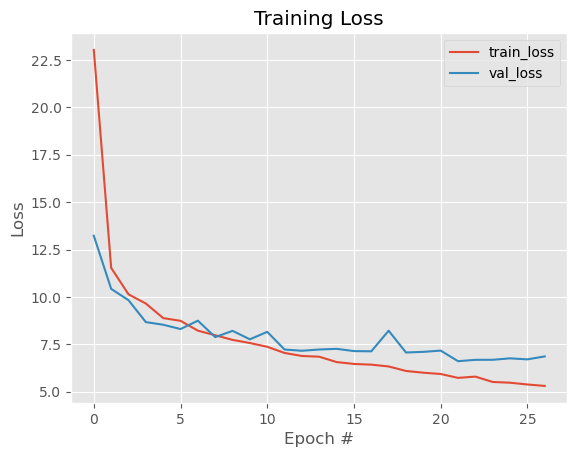

lr:  0.005  Hour_res:  2  Hex_res:  9
Epoch 1/200
429/429 [==============================] - 11s 25ms/step - loss: 23.9002 - val_loss: 11.8174
Epoch 2/200
429/429 [==============================] - 10s 23ms/step - loss: 11.4381 - val_loss: 11.3934
Epoch 3/200
429/429 [==============================] - 10s 23ms/step - loss: 10.0919 - val_loss: 9.9212
Epoch 4/200
429/429 [==============================] - 10s 23ms/step - loss: 9.5208 - val_loss: 9.2127
Epoch 5/200
429/429 [==============================] - 10s 23ms/step - loss: 8.7612 - val_loss: 8.4840
Epoch 6/200
429/429 [==============================] - 10s 23ms/step - loss: 8.5408 - val_loss: 8.3522
Epoch 7/200
429/429 [==============================] - 10s 23ms/step - loss: 8.2879 - val_loss: 8.4286
Epoch 8/200
429/429 [==============================] - 10s 23ms/step - loss: 8.0025 - val_loss: 7.8977
Epoch 9/200
429/429 [==============================] - 10s 23ms/step - loss: 7.6445 - val_loss: 8.8317
Epoch 10/200
429/429 [========

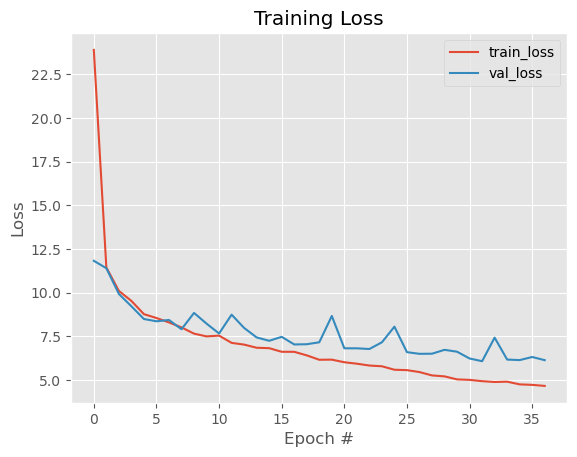

lr:  0.005  Hour_res:  6  Hex_res:  3
Epoch 1/200
378/378 [==============================] - 8s 20ms/step - loss: 134.0854 - val_loss: 139.3978
Epoch 2/200
378/378 [==============================] - 8s 21ms/step - loss: 130.6959 - val_loss: 139.1288
Epoch 3/200
378/378 [==============================] - 11s 29ms/step - loss: 128.7697 - val_loss: 131.7523
Epoch 4/200
378/378 [==============================] - 10s 27ms/step - loss: 83.2266 - val_loss: 41.9173
Epoch 5/200
378/378 [==============================] - 11s 29ms/step - loss: 34.2406 - val_loss: 26.5552
Epoch 6/200
378/378 [==============================] - 9s 24ms/step - loss: 29.2881 - val_loss: 24.0853
Epoch 7/200
378/378 [==============================] - 8s 21ms/step - loss: 24.6799 - val_loss: 25.7432
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: 24.0984 - val_loss: 29.6762
Epoch 9/200
378/378 [==============================] - 8s 21ms/step - loss: 22.4000 - val_loss: 22.7129
Epoch 10/200
378/

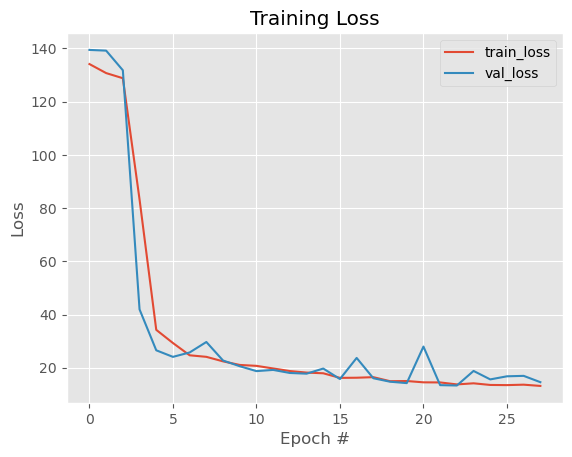

lr:  0.005  Hour_res:  6  Hex_res:  5
Epoch 1/200
378/378 [==============================] - 8s 20ms/step - loss: 134.9257 - val_loss: 129.7480
Epoch 2/200
378/378 [==============================] - 8s 22ms/step - loss: 135.9819 - val_loss: 137.1229
Epoch 3/200
378/378 [==============================] - 8s 22ms/step - loss: 133.9925 - val_loss: 139.4771
Epoch 4/200
378/378 [==============================] - 9s 25ms/step - loss: 129.9082 - val_loss: 133.4539
Epoch 5/200
378/378 [==============================] - 8s 21ms/step - loss: 79.6434 - val_loss: 39.1106
Epoch 6/200
378/378 [==============================] - 8s 22ms/step - loss: 35.2834 - val_loss: 48.2829
Epoch 7/200
378/378 [==============================] - 9s 23ms/step - loss: 31.6896 - val_loss: 26.7268
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: 28.1250 - val_loss: 27.5503
Epoch 9/200
378/378 [==============================] - 8s 21ms/step - loss: 25.2949 - val_loss: 21.5683
Epoch 10/200
378/3

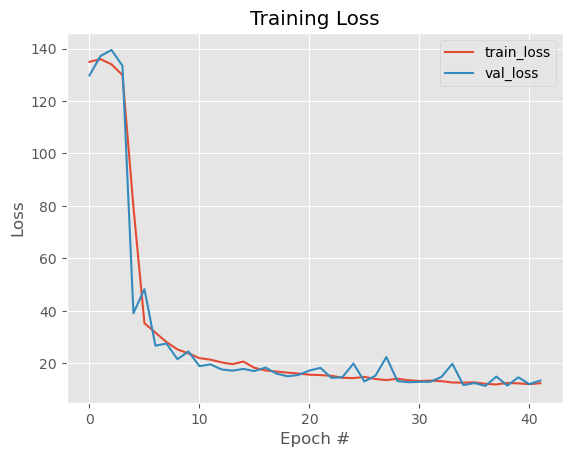

lr:  0.005  Hour_res:  6  Hex_res:  7
Epoch 1/200
378/378 [==============================] - 9s 23ms/step - loss: 63.3548 - val_loss: 28.3549
Epoch 2/200
378/378 [==============================] - 9s 23ms/step - loss: 28.0300 - val_loss: 23.6806
Epoch 3/200
378/378 [==============================] - 8s 21ms/step - loss: 25.7758 - val_loss: 25.7533
Epoch 4/200
378/378 [==============================] - 8s 22ms/step - loss: 24.2580 - val_loss: 26.7940
Epoch 5/200
378/378 [==============================] - 9s 23ms/step - loss: 20.4628 - val_loss: 21.6294
Epoch 6/200
378/378 [==============================] - 8s 21ms/step - loss: 19.8633 - val_loss: 27.8725
Epoch 7/200
378/378 [==============================] - 8s 21ms/step - loss: 18.6334 - val_loss: 16.4154
Epoch 8/200
378/378 [==============================] - 8s 21ms/step - loss: 17.2692 - val_loss: 20.3236
Epoch 9/200
378/378 [==============================] - 8s 21ms/step - loss: 17.2403 - val_loss: 17.8662
Epoch 10/200
378/378 [====

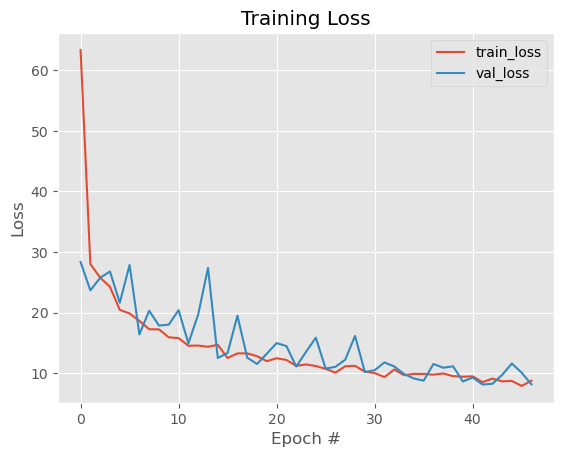

lr:  0.005  Hour_res:  6  Hex_res:  9
Epoch 1/200
378/378 [==============================] - 11s 27ms/step - loss: 60.6722 - val_loss: 27.3333
Epoch 2/200
378/378 [==============================] - 9s 23ms/step - loss: 28.3039 - val_loss: 27.5046
Epoch 3/200
378/378 [==============================] - 9s 23ms/step - loss: 25.0285 - val_loss: 23.3713
Epoch 4/200
378/378 [==============================] - 8s 22ms/step - loss: 21.5038 - val_loss: 20.1842
Epoch 5/200
378/378 [==============================] - 9s 23ms/step - loss: 20.5921 - val_loss: 24.4721
Epoch 6/200
378/378 [==============================] - 8s 22ms/step - loss: 19.7414 - val_loss: 24.2545
Epoch 7/200
378/378 [==============================] - 9s 24ms/step - loss: 18.4773 - val_loss: 22.7132
Epoch 8/200
378/378 [==============================] - 9s 24ms/step - loss: 17.0978 - val_loss: 16.3886
Epoch 9/200
378/378 [==============================] - 9s 23ms/step - loss: 17.1335 - val_loss: 15.9046
Epoch 10/200
378/378 [===

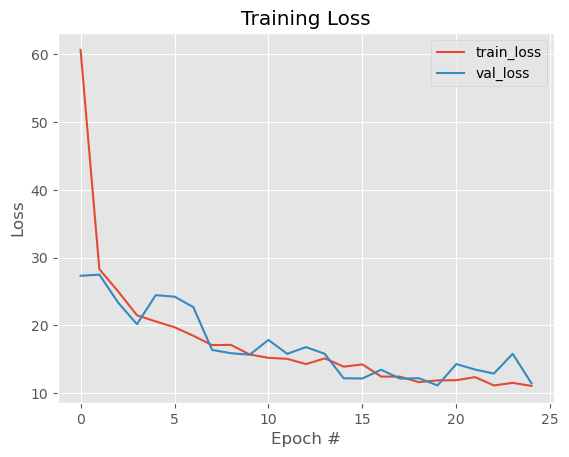

lr:  0.005  Hour_res:  24  Hex_res:  3
Epoch 1/200
323/323 [==============================] - 7s 21ms/step - loss: nan - val_loss: nan
Epoch 2/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 5: early stopping
Testset:

1614/1614 [==============================] - 4s 2ms/step - loss: nan
Test Loss:  nan


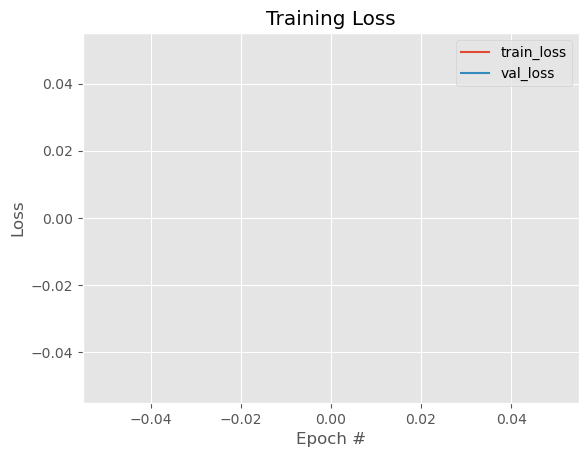

lr:  0.005  Hour_res:  24  Hex_res:  5
Epoch 1/200
323/323 [==============================] - 7s 21ms/step - loss: 480.7728 - val_loss: 465.0210
Epoch 2/200
323/323 [==============================] - 7s 23ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 6s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 6: early stopping
Testset:

1614/1614 [==============================] - 4s 2ms/step - loss: 469.1673
Test Loss:  469.16729736328125


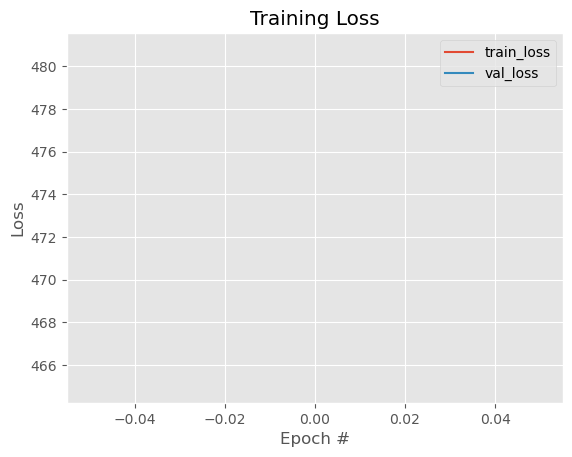

lr:  0.005  Hour_res:  24  Hex_res:  7
Epoch 1/200
323/323 [==============================] - 7s 21ms/step - loss: 495.4104 - val_loss: 485.8530
Epoch 2/200
323/323 [==============================] - 7s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 7s 21ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 7s 21ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 6/200
323/323 [==============================] - 7s 22ms/step - loss: nan - val_loss: nan
Epoch 6: early stopping
Testset:

1614/1614 [==============================] - 4s 2ms/step - loss: 479.5721
Test Loss:  479.5720520019531


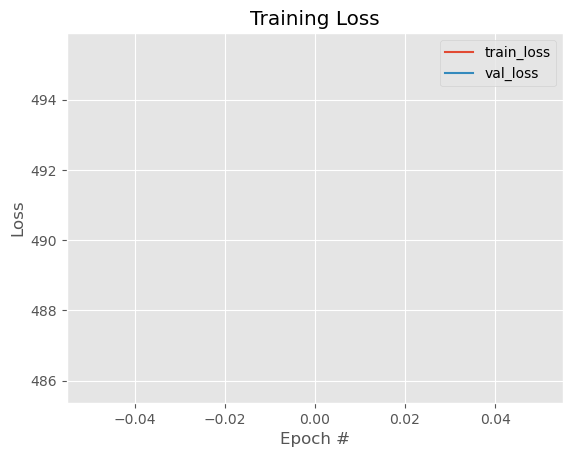

lr:  0.005  Hour_res:  24  Hex_res:  9
Epoch 1/200
323/323 [==============================] - 8s 25ms/step - loss: 470.3497 - val_loss: 470.8672
Epoch 2/200
323/323 [==============================] - 8s 24ms/step - loss: 480.7093 - val_loss: 519.5415
Epoch 3/200
323/323 [==============================] - 8s 23ms/step - loss: 470.3377 - val_loss: 469.9155
Epoch 4/200
323/323 [==============================] - 8s 24ms/step - loss: 466.9357 - val_loss: 469.9141
Epoch 5/200
323/323 [==============================] - 7s 23ms/step - loss: 466.9435 - val_loss: 469.9636
Epoch 6/200
323/323 [==============================] - 8s 24ms/step - loss: 466.9352 - val_loss: 469.9381
Epoch 7/200
323/323 [==============================] - 8s 24ms/step - loss: 466.9311 - val_loss: 469.9812
Epoch 8/200
323/323 [==============================] - 8s 24ms/step - loss: 466.9226 - val_loss: 469.9278
Epoch 9/200
323/323 [==============================] - 8s 23ms/step - loss: 466.9303 - val_loss: 469.9507
Epoch 9

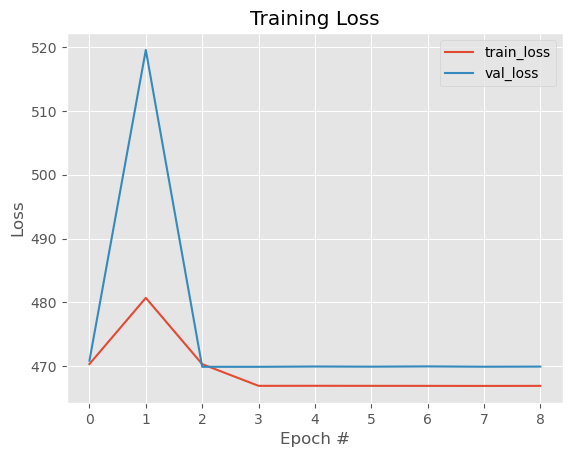

lr:  0.01  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7732 - val_loss: 23.7149
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 23.7904 - val_loss: 23.6370
Epoch 3/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8299 - val_loss: 23.5796
Epoch 4/200
471/471 [==============================] - 10s 22ms/step - loss: 23.8029 - val_loss: 23.5798
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8029 - val_loss: 23.5795
Epoch 6/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8031 - val_loss: 23.5800
Epoch 7/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8032 - val_loss: 23.5799
Epoch 8/200
471/471 [==============================] - 10s 21ms/step - loss: 23.8028 - val_loss: 23.5800
Epoch 8: early stopping
Testset:

2352/2352 [==============================] - 6s 2ms/step - loss: 23.8204
Test Loss:  23.8

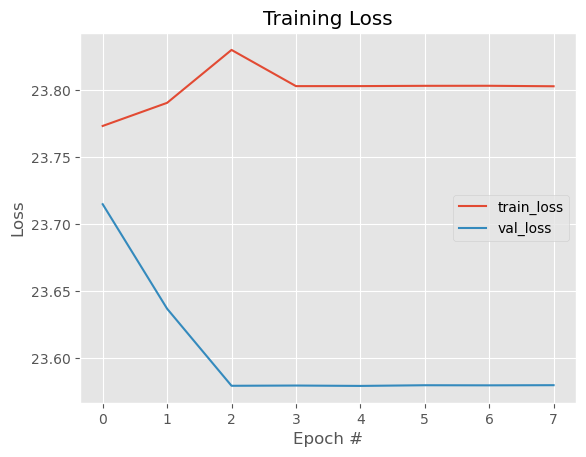

lr:  0.01  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 11s 22ms/step - loss: 23.5052 - val_loss: 23.7401
Epoch 2/200
471/471 [==============================] - 10s 21ms/step - loss: 23.6323 - val_loss: 21.9931
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 23.4776 - val_loss: 23.9533
Epoch 4/200
471/471 [==============================] - 10s 21ms/step - loss: 23.1776 - val_loss: 23.9971
Epoch 5/200
471/471 [==============================] - 10s 21ms/step - loss: 23.1766 - val_loss: 15.0040
Epoch 6/200
471/471 [==============================] - 10s 21ms/step - loss: 10.9745 - val_loss: 9.5510
Epoch 7/200
471/471 [==============================] - 10s 20ms/step - loss: 8.4689 - val_loss: 8.3255
Epoch 8/200
471/471 [==============================] - 10s 21ms/step - loss: 7.2982 - val_loss: 6.9896
Epoch 9/200
471/471 [==============================] - 10s 21ms/step - loss: 6.7495 - val_loss: 6.2232
Epoch 10/200
471/471 [===

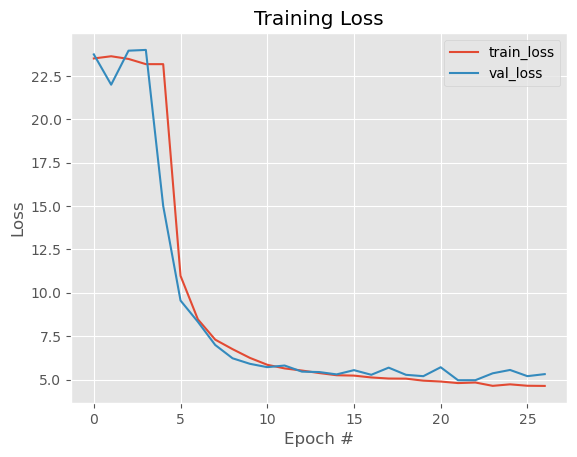

lr:  0.01  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 11s 23ms/step - loss: 11.3780 - val_loss: 7.7034
Epoch 2/200
471/471 [==============================] - 10s 22ms/step - loss: 6.5411 - val_loss: 6.7694
Epoch 3/200
471/471 [==============================] - 11s 23ms/step - loss: 6.0663 - val_loss: 5.5464
Epoch 4/200
471/471 [==============================] - 10s 22ms/step - loss: 5.6326 - val_loss: 5.5251
Epoch 5/200
471/471 [==============================] - 11s 22ms/step - loss: 5.5005 - val_loss: 5.2621
Epoch 6/200
471/471 [==============================] - 10s 22ms/step - loss: 5.1943 - val_loss: 5.3871
Epoch 7/200
471/471 [==============================] - 10s 22ms/step - loss: 5.1139 - val_loss: 5.1420
Epoch 8/200
471/471 [==============================] - 11s 23ms/step - loss: 4.9883 - val_loss: 4.9776
Epoch 9/200
471/471 [==============================] - 11s 23ms/step - loss: 4.8533 - val_loss: 5.0122
Epoch 10/200
471/471 [=============

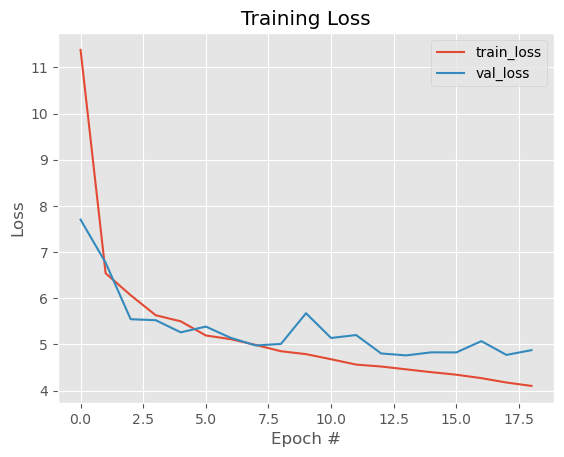

lr:  0.01  Hour_res:  1  Hex_res:  9
Epoch 1/200
471/471 [==============================] - 12s 24ms/step - loss: 12.1242 - val_loss: 6.9274
Epoch 2/200
471/471 [==============================] - 11s 23ms/step - loss: 6.6900 - val_loss: 6.8994
Epoch 3/200
471/471 [==============================] - 11s 23ms/step - loss: 6.0494 - val_loss: 5.7332
Epoch 4/200
471/471 [==============================] - 11s 24ms/step - loss: 5.6306 - val_loss: 5.4227
Epoch 5/200
471/471 [==============================] - 11s 23ms/step - loss: 5.4279 - val_loss: 5.4846
Epoch 6/200
471/471 [==============================] - 11s 24ms/step - loss: 5.2458 - val_loss: 5.2169
Epoch 7/200
471/471 [==============================] - 11s 23ms/step - loss: 5.1411 - val_loss: 5.2040
Epoch 8/200
471/471 [==============================] - 11s 23ms/step - loss: 5.0379 - val_loss: 5.9375
Epoch 9/200
471/471 [==============================] - 11s 24ms/step - loss: 4.8784 - val_loss: 5.1767
Epoch 10/200
471/471 [=============

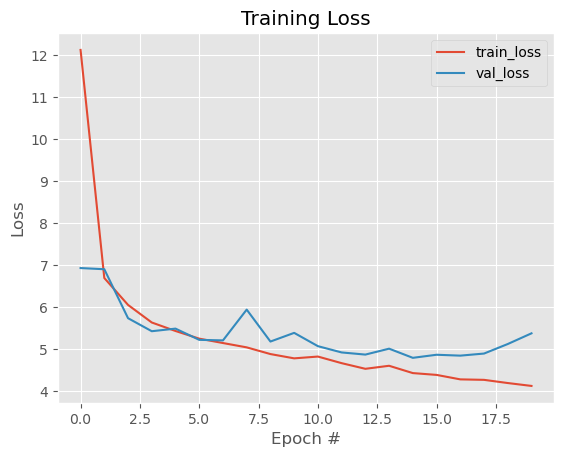

lr:  0.01  Hour_res:  2  Hex_res:  3
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 46.6855 - val_loss: 47.4158
Epoch 2/200
429/429 [==============================] - 9s 20ms/step - loss: 46.9626 - val_loss: 47.1796
Epoch 3/200
429/429 [==============================] - 9s 21ms/step - loss: 40.7588 - val_loss: 21.4990
Epoch 4/200
429/429 [==============================] - 9s 21ms/step - loss: 19.0854 - val_loss: 16.4552
Epoch 5/200
429/429 [==============================] - 9s 20ms/step - loss: 14.5179 - val_loss: 12.9764
Epoch 6/200
429/429 [==============================] - 9s 21ms/step - loss: 12.7478 - val_loss: 10.8170
Epoch 7/200
429/429 [==============================] - 9s 20ms/step - loss: 11.4498 - val_loss: 10.6503
Epoch 8/200
429/429 [==============================] - 9s 21ms/step - loss: 10.2787 - val_loss: 10.1353
Epoch 9/200
429/429 [==============================] - 9s 20ms/step - loss: 9.6672 - val_loss: 9.0594
Epoch 10/200
429/429 [======

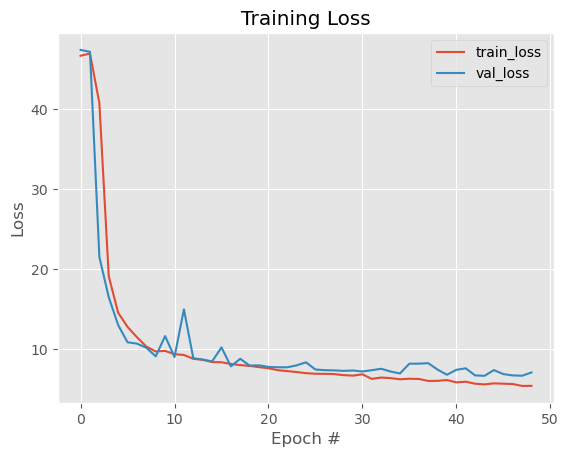

lr:  0.01  Hour_res:  2  Hex_res:  5
Epoch 1/200
429/429 [==============================] - 9s 21ms/step - loss: 46.3949 - val_loss: 45.1052
Epoch 2/200
429/429 [==============================] - 9s 20ms/step - loss: 46.5730 - val_loss: 46.8940
Epoch 3/200
429/429 [==============================] - 9s 20ms/step - loss: 38.7978 - val_loss: 20.5562
Epoch 4/200
429/429 [==============================] - 9s 20ms/step - loss: 17.3622 - val_loss: 13.5312
Epoch 5/200
429/429 [==============================] - 9s 21ms/step - loss: 13.1029 - val_loss: 13.9518
Epoch 6/200
429/429 [==============================] - 9s 21ms/step - loss: 11.5223 - val_loss: 10.4248
Epoch 7/200
429/429 [==============================] - 9s 20ms/step - loss: 10.8805 - val_loss: 10.2816
Epoch 8/200
429/429 [==============================] - 9s 20ms/step - loss: 10.0898 - val_loss: 10.0977
Epoch 9/200
429/429 [==============================] - 9s 20ms/step - loss: 9.9170 - val_loss: 9.9664
Epoch 10/200
429/429 [=======

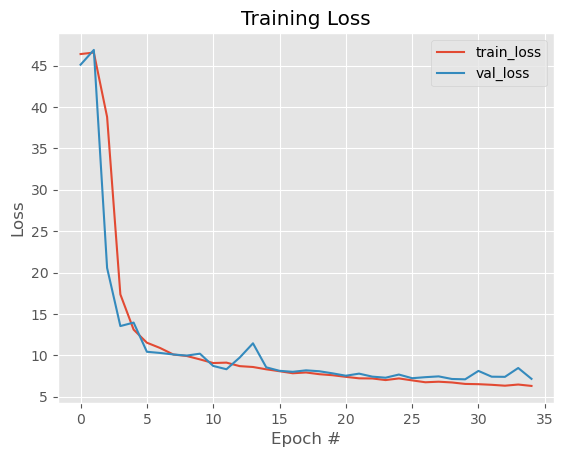

lr:  0.01  Hour_res:  2  Hex_res:  7
Epoch 1/200
429/429 [==============================] - 10s 22ms/step - loss: 21.5747 - val_loss: 12.7608
Epoch 2/200
429/429 [==============================] - 9s 21ms/step - loss: 12.0532 - val_loss: 14.4186
Epoch 3/200
429/429 [==============================] - 9s 21ms/step - loss: 10.6558 - val_loss: 11.4241
Epoch 4/200
429/429 [==============================] - 9s 22ms/step - loss: 9.8593 - val_loss: 9.3351
Epoch 5/200
429/429 [==============================] - 9s 22ms/step - loss: 9.4054 - val_loss: 11.0961
Epoch 6/200
429/429 [==============================] - 10s 23ms/step - loss: 9.1787 - val_loss: 8.3902
Epoch 7/200
429/429 [==============================] - 10s 24ms/step - loss: 8.5282 - val_loss: 8.2583
Epoch 8/200
429/429 [==============================] - 11s 25ms/step - loss: 8.1672 - val_loss: 8.3734
Epoch 9/200
429/429 [==============================] - 10s 23ms/step - loss: 8.0613 - val_loss: 8.9494
Epoch 10/200
429/429 [===========

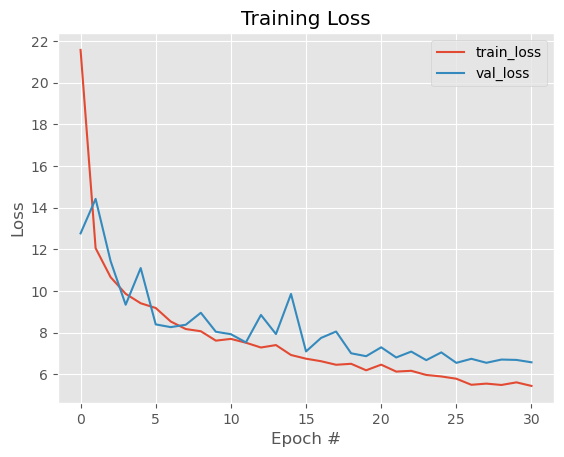

lr:  0.01  Hour_res:  2  Hex_res:  9
Epoch 1/200
429/429 [==============================] - 11s 24ms/step - loss: 21.2128 - val_loss: 11.6866
Epoch 2/200
429/429 [==============================] - 11s 25ms/step - loss: 11.8917 - val_loss: 10.5908
Epoch 3/200
429/429 [==============================] - 10s 23ms/step - loss: 10.4669 - val_loss: 9.1526
Epoch 4/200
429/429 [==============================] - 11s 25ms/step - loss: 9.9513 - val_loss: 9.8449
Epoch 5/200
429/429 [==============================] - 10s 23ms/step - loss: 9.6929 - val_loss: 8.4595
Epoch 6/200
429/429 [==============================] - 10s 23ms/step - loss: 8.7087 - val_loss: 9.9199
Epoch 7/200
429/429 [==============================] - 10s 23ms/step - loss: 8.5028 - val_loss: 8.5476
Epoch 8/200
429/429 [==============================] - 10s 22ms/step - loss: 8.2777 - val_loss: 8.8647
Epoch 9/200
429/429 [==============================] - 10s 23ms/step - loss: 8.0192 - val_loss: 8.1775
Epoch 10/200
429/429 [=========

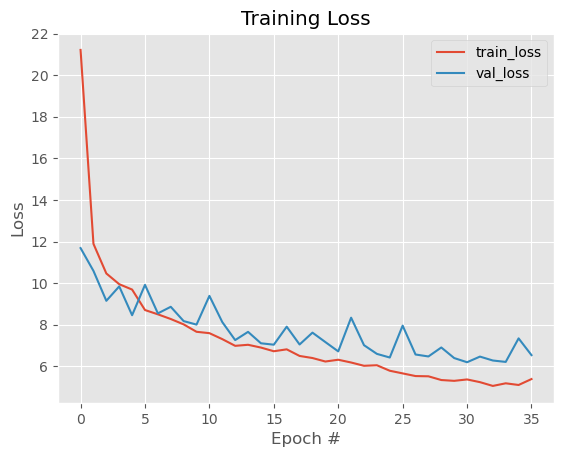

lr:  0.01  Hour_res:  6  Hex_res:  3
Epoch 1/200
378/378 [==============================] - 8s 21ms/step - loss: 136.4872 - val_loss: 136.7155
Epoch 2/200
378/378 [==============================] - 8s 21ms/step - loss: 136.7350 - val_loss: 133.4530
Epoch 3/200
378/378 [==============================] - 8s 21ms/step - loss: 134.7752 - val_loss: 129.3118
Epoch 4/200
378/378 [==============================] - 8s 20ms/step - loss: nan - val_loss: nan
Epoch 5/200
378/378 [==============================] - 8s 20ms/step - loss: nan - val_loss: nan
Epoch 6/200
378/378 [==============================] - 8s 21ms/step - loss: nan - val_loss: nan
Epoch 7/200
378/378 [==============================] - 8s 22ms/step - loss: nan - val_loss: nan
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: nan - val_loss: nan
Epoch 8: early stopping
Testset:

1888/1888 [==============================] - 5s 2ms/step - loss: 129.6909
Test Loss:  129.6908721923828


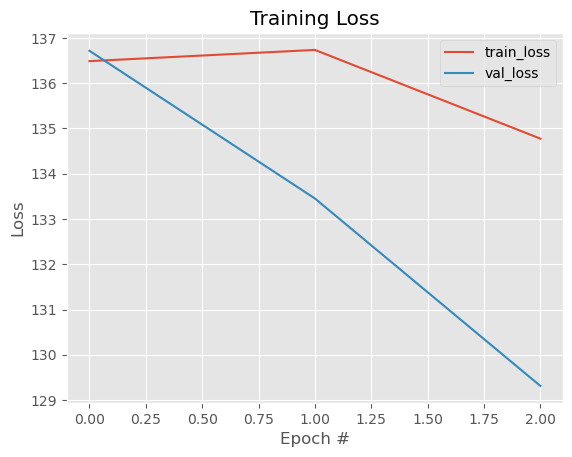

lr:  0.01  Hour_res:  6  Hex_res:  5
Epoch 1/200
378/378 [==============================] - 8s 21ms/step - loss: nan - val_loss: nan
Epoch 2/200
378/378 [==============================] - 8s 20ms/step - loss: nan - val_loss: nan
Epoch 3/200
378/378 [==============================] - 8s 21ms/step - loss: nan - val_loss: nan
Epoch 4/200
378/378 [==============================] - 8s 21ms/step - loss: nan - val_loss: nan
Epoch 5/200
378/378 [==============================] - 9s 23ms/step - loss: nan - val_loss: nan
Epoch 5: early stopping
Testset:

1888/1888 [==============================] - 4s 2ms/step - loss: nan
Test Loss:  nan


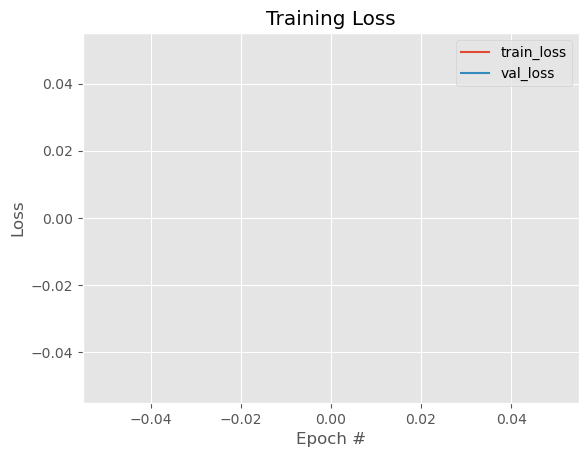

lr:  0.01  Hour_res:  6  Hex_res:  7
Epoch 1/200
378/378 [==============================] - 9s 22ms/step - loss: 91.3083 - val_loss: 60.2171
Epoch 2/200
378/378 [==============================] - 8s 21ms/step - loss: 35.3513 - val_loss: 31.1670
Epoch 3/200
378/378 [==============================] - 8s 22ms/step - loss: 30.2153 - val_loss: 26.0513
Epoch 4/200
378/378 [==============================] - 9s 23ms/step - loss: 25.9450 - val_loss: 23.3246
Epoch 5/200
378/378 [==============================] - 8s 22ms/step - loss: 23.0960 - val_loss: 21.1819
Epoch 6/200
378/378 [==============================] - 8s 21ms/step - loss: 21.7360 - val_loss: 21.5297
Epoch 7/200
378/378 [==============================] - 8s 22ms/step - loss: 21.4176 - val_loss: 18.5780
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: 20.1771 - val_loss: 20.2029
Epoch 9/200
378/378 [==============================] - 8s 21ms/step - loss: 20.4620 - val_loss: 22.9635
Epoch 10/200
378/378 [=====

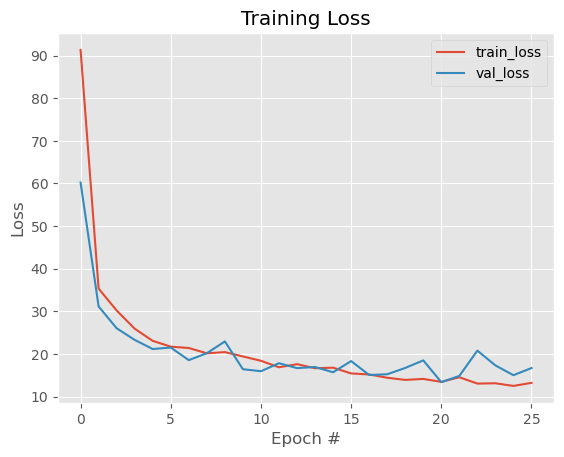

lr:  0.01  Hour_res:  6  Hex_res:  9
Epoch 1/200
378/378 [==============================] - 10s 24ms/step - loss: 136.0381 - val_loss: 133.7169
Epoch 2/200
378/378 [==============================] - 9s 23ms/step - loss: 102.6583 - val_loss: 39.0627
Epoch 3/200
378/378 [==============================] - 9s 23ms/step - loss: 41.7991 - val_loss: 29.0290
Epoch 4/200
378/378 [==============================] - 8s 22ms/step - loss: 30.8052 - val_loss: 24.8919
Epoch 5/200
378/378 [==============================] - 8s 22ms/step - loss: 26.4508 - val_loss: 22.7414
Epoch 6/200
378/378 [==============================] - 8s 22ms/step - loss: 23.9740 - val_loss: 26.0951
Epoch 7/200
378/378 [==============================] - 9s 23ms/step - loss: 23.3462 - val_loss: 20.2131
Epoch 8/200
378/378 [==============================] - 8s 22ms/step - loss: 22.5335 - val_loss: 20.8345
Epoch 9/200
378/378 [==============================] - 9s 23ms/step - loss: 21.0459 - val_loss: 21.2002
Epoch 10/200
378/378 [=

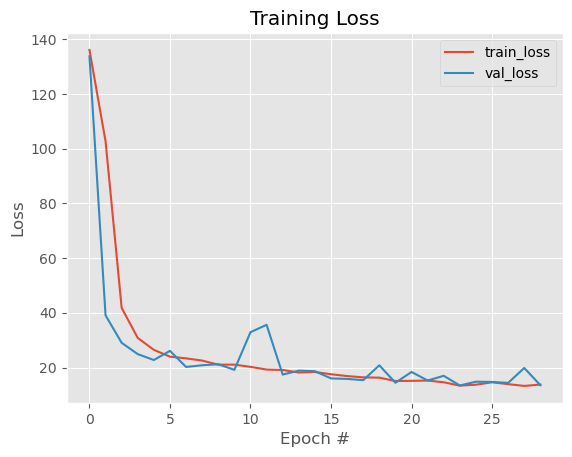

lr:  0.01  Hour_res:  24  Hex_res:  3
Epoch 1/200
323/323 [==============================] - 7s 21ms/step - loss: 481.4824 - val_loss: 462.7039
Epoch 2/200
323/323 [==============================] - 7s 20ms/step - loss: 469.8319 - val_loss: 462.7879
Epoch 3/200
323/323 [==============================] - 7s 21ms/step - loss: 469.7828 - val_loss: 462.6569
Epoch 4/200
323/323 [==============================] - 7s 21ms/step - loss: 469.7612 - val_loss: 462.6867
Epoch 5/200
323/323 [==============================] - 7s 21ms/step - loss: 469.7851 - val_loss: 462.7845
Epoch 6/200
323/323 [==============================] - 7s 20ms/step - loss: 469.7398 - val_loss: 462.7682
Epoch 7/200
323/323 [==============================] - 7s 21ms/step - loss: 469.7381 - val_loss: 462.7057
Epoch 8/200
323/323 [==============================] - 7s 20ms/step - loss: 469.7840 - val_loss: 462.6494
Epoch 9/200
323/323 [==============================] - 7s 20ms/step - loss: 469.7719 - val_loss: 462.6959
Epoch 10

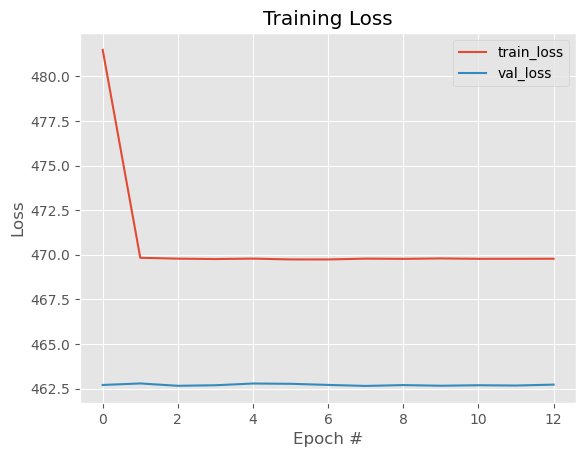

lr:  0.01  Hour_res:  24  Hex_res:  5
Epoch 1/200
323/323 [==============================] - 8s 25ms/step - loss: 480.9209 - val_loss: 471.1975
Epoch 2/200
323/323 [==============================] - 10s 30ms/step - loss: 469.5269 - val_loss: 470.8156
Epoch 3/200
323/323 [==============================] - 8s 26ms/step - loss: 469.4885 - val_loss: 471.3743
Epoch 4/200
323/323 [==============================] - 7s 22ms/step - loss: 469.4832 - val_loss: 470.8353
Epoch 5/200
323/323 [==============================] - 7s 23ms/step - loss: 469.4763 - val_loss: 470.8347
Epoch 6/200
323/323 [==============================] - 8s 24ms/step - loss: 469.4993 - val_loss: 471.1785
Epoch 7/200
323/323 [==============================] - 7s 22ms/step - loss: 469.5060 - val_loss: 471.0305
Epoch 7: early stopping
Testset:

1614/1614 [==============================] - 4s 2ms/step - loss: 464.0559
Test Loss:  464.055908203125


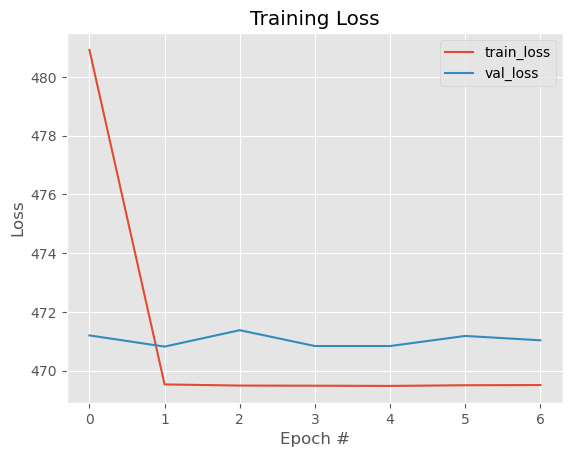

lr:  0.01  Hour_res:  24  Hex_res:  7
Epoch 1/200
323/323 [==============================] - 8s 23ms/step - loss: nan - val_loss: nan
Epoch 2/200
323/323 [==============================] - 8s 26ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 9s 28ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 9s 29ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 9s 29ms/step - loss: nan - val_loss: nan
Epoch 5: early stopping
Testset:

1614/1614 [==============================] - 5s 3ms/step - loss: nan
Test Loss:  nan


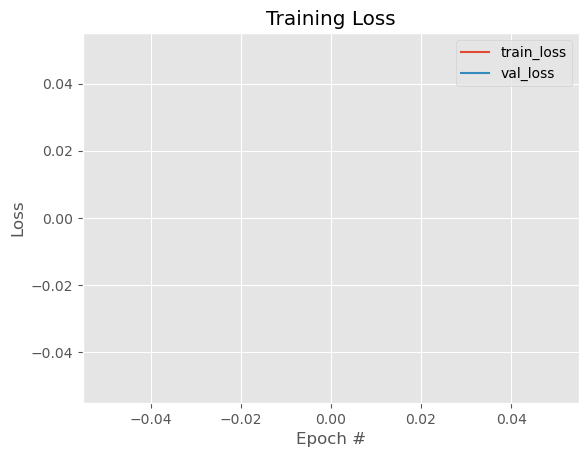

lr:  0.01  Hour_res:  24  Hex_res:  9
Epoch 1/200
323/323 [==============================] - 9s 26ms/step - loss: 483.1012 - val_loss: 564.1768
Epoch 2/200
323/323 [==============================] - 8s 24ms/step - loss: nan - val_loss: nan
Epoch 3/200
323/323 [==============================] - 9s 26ms/step - loss: nan - val_loss: nan
Epoch 4/200
323/323 [==============================] - 8s 25ms/step - loss: nan - val_loss: nan
Epoch 5/200
323/323 [==============================] - 8s 24ms/step - loss: nan - val_loss: nan
Epoch 6/200
323/323 [==============================] - 8s 24ms/step - loss: nan - val_loss: nan
Epoch 6: early stopping
Testset:

1614/1614 [==============================] - 4s 3ms/step - loss: 563.5060
Test Loss:  563.5060424804688


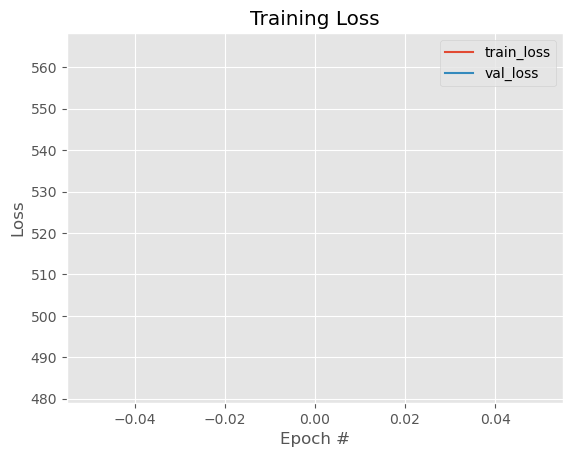

lr:  0.03  Hour_res:  1  Hex_res:  3
Epoch 1/200
471/471 [==============================] - 12s 24ms/step - loss: 21.1638 - val_loss: 12.3084
Epoch 2/200
471/471 [==============================] - 10s 22ms/step - loss: 8.8882 - val_loss: 7.5606
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 7.2033 - val_loss: 6.5180
Epoch 4/200
471/471 [==============================] - 11s 23ms/step - loss: 6.6629 - val_loss: 6.1039
Epoch 5/200
471/471 [==============================] - 10s 22ms/step - loss: 5.9972 - val_loss: 6.1565
Epoch 6/200
471/471 [==============================] - 11s 23ms/step - loss: 5.9327 - val_loss: 6.0474
Epoch 7/200
471/471 [==============================] - 11s 23ms/step - loss: 5.7843 - val_loss: 5.6596
Epoch 8/200
471/471 [==============================] - 11s 24ms/step - loss: 5.5757 - val_loss: 5.6065
Epoch 9/200
471/471 [==============================] - 11s 24ms/step - loss: 5.4756 - val_loss: 5.6413
Epoch 10/200
471/471 [============

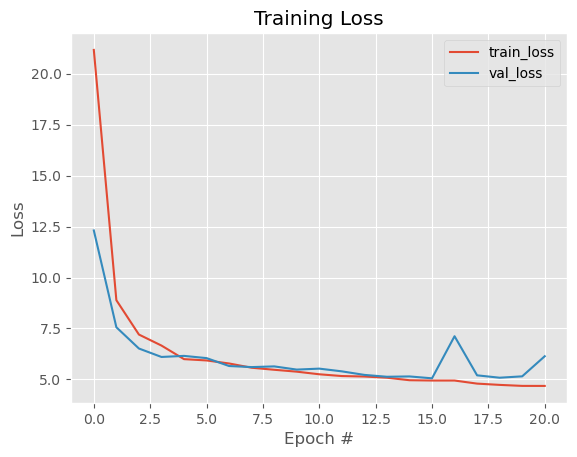

lr:  0.03  Hour_res:  1  Hex_res:  5
Epoch 1/200
471/471 [==============================] - 11s 23ms/step - loss: 23.6439 - val_loss: 24.5859
Epoch 2/200
471/471 [==============================] - 11s 23ms/step - loss: 16.0505 - val_loss: 9.0384
Epoch 3/200
471/471 [==============================] - 10s 22ms/step - loss: 7.9282 - val_loss: 6.8159
Epoch 4/200
471/471 [==============================] - 11s 24ms/step - loss: 6.8607 - val_loss: 6.8866
Epoch 5/200
471/471 [==============================] - 12s 25ms/step - loss: 6.4638 - val_loss: 6.1988
Epoch 6/200
471/471 [==============================] - 14s 30ms/step - loss: 6.0172 - val_loss: 5.8882
Epoch 7/200
471/471 [==============================] - 11s 23ms/step - loss: 5.8534 - val_loss: 5.7323
Epoch 8/200
471/471 [==============================] - 10s 20ms/step - loss: 5.8049 - val_loss: 7.1562
Epoch 9/200
471/471 [==============================] - 10s 20ms/step - loss: 5.6328 - val_loss: 5.7693
Epoch 10/200
471/471 [===========

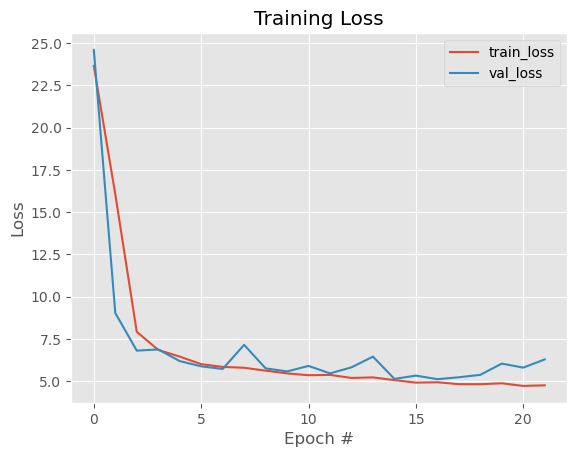

lr:  0.03  Hour_res:  1  Hex_res:  7
Epoch 1/200
471/471 [==============================] - 11s 22ms/step - loss: 23.4685 - val_loss: 23.4157
Epoch 2/200
414/471 [=========================>....] - ETA: 1s - loss: 15.6281

In [10]:
lr = [0.01, 0.03, 0.05]
resolution = [1, 2, 6, 24]
hex_res = [3, 5, 7]
result_list = []
data_sample = work_data.sample(10000000)
for i in lr:
    for j in resolution:
        for k in hex_res:
            data1 = create_dataset_more_data(data_sample,resolution=j,h3_res = k)
            network1 = models.Sequential()
            print(data1.shape)


            network1.add(layers.Dense(512, activation='relu', input_shape=(data1.shape[1]-1,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(512, activation='relu', input_shape=(512,)))
            network1.add(layers.Dense(1, activation='linear'))
          
            print("lr: ", i, " Hour_res: ", j, " Hex_res: ", k)
            TN1 = Train_Net(data1, network1, batch_size = 512, epochs = 200, learning_rate=i)
            loss, H, epochs_plot = TN1.train_net()
            result_list.append("lr: "+ str(i)+ " Hour_res: "+ str(j)+ " Hex_res: "+str(k)+ " Epochs before stopping:"+ str(epochs_plot) + " Test_loss: "+ str(loss) +" Demand mean value: " +str(data1[:,-1:].mean()))
result_list

In [ ]:
lr:  0.03  Hour_res:  1  Hex_res:  7

In [12]:
result_list

In [26]:
data_sample = work_data.sample(10000000)
data1 = create_dataset_more_data(work_data,resolution=24,h3_res = 5)
network1 = models.Sequential()
print(data1.shape)


network1.add(layers.Dense(512-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(data1.shape[1]-1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(1, activation='relu', input_shape=(data1.shape[1]-1,)))
network1.add(layers.Dense(1, activation='linear'))

TN1 = Train_Net(data1, network1, batch_size = 128, epochs = 100, learning_rate=0.01)
loss, H = TN1.train_net()

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
16500977    0.0
16500978    0.0
16500979    0.0
16500980    0.0
16500981    0.0
Name: new_hour, Length: 16500982, dtype: float64
(274165, 615)
Epoch 1/100
1371/1371 [==============================] - 25s 18ms/step - loss: 763.6591 - val_loss: 758.5094
Epoch 2/100
1371/1371 [==============================] - 25s 18ms/step - loss: 748.6364 - val_loss: 752.0361
Epoch 3/100
1371/1371 [==============================] - 25s 18ms/step - loss: 744.4966 - val_loss: 749.3785
Epoch 4/100
1371/1371 [==============================] - 24s 18ms/step - loss: 742.6226 - val_loss: 748.0114
Epoch 5/100
1371/1371 [==============================] - 25s 18ms/step - loss: 741.6284 - val_loss: 747.2383
Epoch 6/100
1371/1371 [==============================] - 25s 18ms/step - loss: 741.0651 - val_loss: 746.7830
Epoch 7/100
1371/1371 [==============================] - 25s 18ms/step - loss: 740.7338 - val_loss: 746.513

KeyboardInterrupt: 